# PART 2: Reddit NLP Project: Extract symptoms by QA (Question-Answering)

In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

No GPU available, using the CPU instead.


In [2]:
# !pip install datasets
# !pip install transformers
import pandas as pd
import numpy as np
from datasets import load_dataset, load_metric
from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
from transformers import BertForQuestionAnswering,BertTokenizer,BertModel,AutoTokenizer # AdamW, BertConfig
import torch 
import matplotlib.pyplot as plt

### Look at positive "body"

In [470]:
#for colab: 
# from google.colab import drive
# drive.mount('/content/drive')

In [87]:
#for local:
positive_data = pd.read_csv('./output_files/positive_data.csv')
#for colab:
#positive_data = pd.read_csv('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/positive_data.csv')

positive_data.dropna(axis=0, subset=['body'], inplace=True) #remove row with nan body
positive_len_bert, positive_len_biobert = [],[] #record length

tokenizer_large = AutoTokenizer.from_pretrained('bert-large-uncased')
tokenizer_biobert_large = AutoTokenizer.from_pretrained('dmis-lab/biobert-large-cased-v1.1-squad')

for sent in positive_data['body']:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer_large.encode(sent, add_special_tokens=True)
    positive_len_bert.append(len(input_ids))
    input_ids = tokenizer_biobert_large.encode(sent, add_special_tokens=True)
    positive_len_biobert.append(len(input_ids))
print('number of positive users:', len(set(positive_data['author'])))
print('number of positive body:', len(positive_data))
print('quantile len(large BERT)',np.quantile(positive_len_bert,[0, 0.25, 0.5, 0.75, 1]))
print('quantile len(large BioBERT)',np.quantile(positive_len_biobert,[0, 0.25, 0.5, 0.75, 1]))

### Load BERT_large Model and BioBERT_large model

In [4]:
bert_large_finetuned_model = BertForQuestionAnswering.from_pretrained('bert-large-uncased-whole-word-masking-finetuned-squad')
biobert_large_finetuned_model = BertForQuestionAnswering.from_pretrained('dmis-lab/biobert-large-cased-v1.1-squad')
args_large = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "epoch",
    learning_rate= 3e-5,  
    per_device_train_batch_size = 16,  
    per_device_eval_batch_size= 16,   
    num_train_epochs= 2, 
    weight_decay=0.01)
trainer_large_BERT = Trainer(
    bert_large_finetuned_model,
    args_large,
    #train_dataset=tokenized_datasets["train"],
    #eval_dataset=tokenized_datasets["validation"],
    #data_collator=data_collator,
    tokenizer=tokenizer_large)
trainer_large_BioBERT = Trainer(
    biobert_large_finetuned_model,
    args_large,
    #train_dataset=tokenized_datasets["train"],
    #eval_dataset=tokenized_datasets["validation"],
    #data_collator=data_collator,
    tokenizer=tokenizer_biobert_large)

### Create positive QA dataset

In [125]:
#Create QA Positive dataset
from datasets import Dataset

positive_data_dic = {'id':[], 'title':[], "context":[], "answers":[], "question":[] }
for k in range(len(positive_data)):
    positive_data_dic['id'] += [positive_data['author'].iloc[k] + positive_data['date'].iloc[k]]     #author + time
    positive_data_dic['title'] += [positive_data['author'].iloc[k] + positive_data['title'].iloc[k]] #author + title
    positive_data_dic['context'] += [positive_data['body'].iloc[k]]     #body 
    positive_data_dic['answers'] += ['']                          #leave the answers blank 
    positive_data_dic['question'] += ['What are my uncomfortable symptoms?']
PositiveData_QUAD = Dataset.from_dict(positive_data_dic)
print(PositiveData_QUAD)

## Example
# print('--------------------- Example ---------------------------------')
# val_data_temp = Dataset.from_dict(PositiveData_QUAD[200:220])
# print(val_data_temp['question'])
# print('------------------------------------------------------')
# val_data_temp['context']

Dataset({
    features: ['id', 'title', 'context', 'answers', 'question'],
    num_rows: 8268
})


### Define (1). Prepare features function and (2).valid answers function

In [53]:
def prepare_validation_features(examples, tokenizer = tokenizer_large):
    max_length = 300 # The maximum length of a feature (question and context)
    doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.
    pad_on_right = tokenizer.padding_side == "right"
    
    # Tokenize our examples with truncation and maybe padding, but keep the overflows using a stride. This results
    # in one example possible giving several features when a context is long, each of those features having a
    # context that overlaps a bit the context of the previous feature.
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    # Since one example might give us several features if it has a long context, we need a map from a feature to
    # its corresponding example. This key gives us just that.
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")

    # We keep the example_id that gave us this feature and we will store the offset mappings.
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        # Grab the sequence corresponding to that example (to know what is the context and what is the question).
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0

        # One example can give several spans, this is the index of the example containing this span of text.
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])

        # Set to None the offset_mapping that are not part of the context so it's easy to determine if a token
        # position is part of the context or not.
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])
        ]

    return tokenized_examples

In [54]:
from tqdm.auto import tqdm
import numpy as np
#max_answer_length = 30 #Eliminate very long answers from our considerations
def postprocess_qa_valid_answers(examples, features, raw_predictions, n_best_size = 20, max_answer_length = 30, 
                                 threshold = .80, start_threshold = 0.4, end_threshold = 0.4, 
                                 tokenizer=tokenizer_large):
    all_start_logits, all_end_logits = raw_predictions
    # Build a map example to its corresponding features.
    example_id_to_index = {k: i for i, k in enumerate(examples["id"])}
    features_per_example = collections.defaultdict(list)
    for i, feature in enumerate(features):
        features_per_example[example_id_to_index[feature["example_id"]]].append(i)

    # The dictionaries we have to fill.
    #predictions = collections.OrderedDict()

    # Logging.
    print(f"Post-processing {len(examples)} example predictions split into {len(features)} features.")

    # Let's loop over all the examples!
    valid_answers = {}
    for example_index, example in enumerate(tqdm(examples)):
        # Those are the indices of the features associated to the current example.
        feature_indices = features_per_example[example_index]

        min_null_score = None # Only used if squad_v2 is True.
        
        context = example["context"]
        context_id = example["id"]
        valid_answers[(context_id, example_index, context)] = {}

        # Looping through all the features associated to the current example.
        for feature_index in feature_indices:
            # We grab the predictions of the model for this feature.
            start_logits = all_start_logits[feature_index]
            end_logits = all_end_logits[feature_index]
            # This is what will allow us to map some the positions in our logits to span of texts in the original
            # context.
            offset_mapping = features[feature_index]["offset_mapping"]

            # Update minimum null prediction.
            cls_index = features[feature_index]["input_ids"].index(tokenizer.cls_token_id)
            feature_null_score = start_logits[cls_index] + end_logits[cls_index]
            if min_null_score is None or min_null_score < feature_null_score:
                min_null_score = feature_null_score

            # Go through all possibilities for the `n_best_size` greater start and end logits.
            start_indexes = np.argsort(start_logits)[-1 : -n_best_size - 1 : -1].tolist()
            end_indexes = np.argsort(end_logits)[-1 : -n_best_size - 1 : -1].tolist()

    
            for start_index in start_indexes:
                for end_index in end_indexes:
                    # Don't consider out-of-scope answers, either because the indices are out of bounds or correspond
                    # to part of the input_ids that are not in the context.
                    if ((start_index >= len(offset_mapping)) or (end_index >= len(offset_mapping)) or (not offset_mapping[start_index]) or (not offset_mapping[end_index]) ):
                        continue
                    # Don't consider answers with a length that is either < 0 or > max_answer_length.
                    if end_index < start_index or end_index - start_index + 1 > max_answer_length:
                        continue
                    start_char = offset_mapping[start_index][0]
                    end_char = offset_mapping[end_index][1]

                    if start_logits[start_index] + end_logits[end_index] >= threshold and start_logits[start_index] >=start_threshold and end_logits[end_index] >=end_threshold:
                        three_scores = (start_logits[start_index]+end_logits[end_index],start_logits[start_index], end_logits[end_index])
                        valid_answers[(context_id, example_index, context)][three_scores] = context[start_char: end_char]
            valid_answers[(context_id, example_index, context)] = dict(sorted(valid_answers[(context_id,example_index, context)].items(), reverse=True)) #sort by 1st scores


    return valid_answers

### Create features and make prediction

In [9]:
validation_features_largeBert = PositiveData_QUAD.map(
    lambda x: prepare_validation_features(x, tokenizer = tokenizer_large),
    batched=True,
    remove_columns=PositiveData_QUAD.column_names
)
validation_features_largeBioBert = PositiveData_QUAD.map(
    lambda x: prepare_validation_features(x, tokenizer = tokenizer_biobert_large),
    batched=True,
    remove_columns=PositiveData_QUAD.column_names
)

In [ ]:
from scipy.special import softmax
<prevent running>
Intermediate_answers_Bertlarge_scores = trainer_large_BERT.predict(validation_features_largeBert).predictions
Intermediate_answers_BioBertlarge_scores = trainer_large_BioBERT.predict(validation_features_largeBioBert).predictions

#return the feature to the original format
validation_features_largeBert.set_format(type=validation_features_largeBert.format["type"], 
                               columns=list(validation_features_largeBert.features.keys()))
validation_features_largeBioBert.set_format(type=validation_features_largeBioBert.format["type"], 
                               columns=list(validation_features_largeBioBert.features.keys()))

### Save and load prediction scores

In [55]:
#for local: 
## Save and read raw prediction scores (start and end)
## np.savetxt('./output_files/Intermediate_answers_Bertlarge_Start_scores.txt', Intermediate_answers_Bertlarge_scores[0])
## np.savetxt('./output_files/Intermediate_answers_Bertlarge_End_scores.txt', Intermediate_answers_Bertlarge_scores[1])
## np.savetxt('./output_files/Intermediate_answers_BioBertlarge_Start_scores.txt', Intermediate_answers_BioBertlarge_scores[0])
## np.savetxt('./output_files/Intermediate_answers_BioBertlarge_End_scores.txt', Intermediate_answers_BioBertlarge_scores[1])

Intermediate_answers_Bertlarge_Start_scores = np.loadtxt('./output_files/Intermediate_answers_Bertlarge_Start_scores.txt', dtype=float)
Intermediate_answers_Bertlarge_End_scores = np.loadtxt('./output_files/Intermediate_answers_Bertlarge_End_scores.txt', dtype=float)
Intermediate_answers_BioBertlarge_Start_scores = np.loadtxt('./output_files/Intermediate_answers_BioBertlarge_Start_scores.txt', dtype=float)
Intermediate_answers_BioBertlarge_End_scores = np.loadtxt('./output_files/Intermediate_answers_BioBertlarge_End_scores.txt', dtype=float)
Intermediate_answers_Bertlarge_scores = (Intermediate_answers_Bertlarge_Start_scores,  Intermediate_answers_Bertlarge_End_scores)
Intermediate_answers_BioBertlarge_scores = (Intermediate_answers_BioBertlarge_Start_scores,  Intermediate_answers_BioBertlarge_End_scores)

#for colab: 
# Intermediate_answers_Bertlarge_Start_scores = np.loadtxt('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Intermediate_answers_Bertlarge_Start_scores.txt', dtype=float)
# Intermediate_answers_Bertlarge_End_scores = np.loadtxt('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Intermediate_answers_Bertlarge_End_scores.txt', dtype=float)
# Intermediate_answers_BioBertlarge_Start_scores = np.loadtxt('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Intermediate_answers_BioBertlarge_Start_scores.txt', dtype=float)
# Intermediate_answers_BioBertlarge_End_scores = np.loadtxt('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Intermediate_answers_BioBertlarge_End_scores.txt', dtype=float)
# Intermediate_answers_Bertlarge_scores = (Intermediate_answers_Bertlarge_Start_scores, Intermediate_answers_Bertlarge_End_scores)
# Intermediate_answers_BioBertlarge_scores = (Intermediate_answers_BioBertlarge_Start_scores, Intermediate_answers_BioBertlarge_End_scores)


### Get answers from BERT/BioBERT models, save and load

In [17]:
import collections

In [ ]:
<prevent running>
Intermediate_answers_Bertlarge = postprocess_qa_valid_answers(PositiveData_QUAD, 
                                               validation_features_largeBert, 
                                               Intermediate_answers_Bertlarge_scores,
                                               threshold = 2, 
                                               start_threshold = 0., 
                                               end_threshold = 0.,
                                               tokenizer=tokenizer_large)
Intermediate_answers_BioBertlarge = postprocess_qa_valid_answers(PositiveData_QUAD, 
                                               validation_features_largeBioBert, 
                                               Intermediate_answers_BioBertlarge_scores,
                                               threshold = 2, 
                                               start_threshold = 0., 
                                               end_threshold = 0.,
                                               tokenizer=tokenizer_biobert_large)
print(len(Intermediate_answers_Bertlarge))
print(len(Intermediate_answers_BioBertlarge))

In [56]:
# for local:
##Save and Load Intermediate_answers (dictionary)
## np.save('./output_files/Intermediate_answers_Bertlarge.npy', Intermediate_answers_Bertlarge) 
## np.save('./output_files/Intermediate_answers_BioBertlarge.npy', Intermediate_answers_BioBertlarge) 

# Load
Intermediate_answers_Bertlarge = np.load('./output_files/Intermediate_answers_Bertlarge.npy',allow_pickle='TRUE').item()
Intermediate_answers_BioBertlarge = np.load('./output_files/Intermediate_answers_BioBertlarge.npy',allow_pickle='TRUE').item()

# for colab:
# Intermediate_answers_Bertlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Intermediate_answers_Bertlarge.npy',allow_pickle='TRUE').item()
# Intermediate_answers_BioBertlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Intermediate_answers_BioBertlarge.npy',allow_pickle='TRUE').item()


## Get  Intermediate Answers (Int_Ans)

### Step 1: Convert original Intermediate_answers to a list of list

In [187]:
## BERT large
ori_Int_Ans_BERTlarge = []
ori_Int_Ans_content_id_BERTlarge = []
ori_Int_Ans_time_id_BERTlarge = []  
for i in range(len(Intermediate_answers_Bertlarge.values())):
    if list(list(Intermediate_answers_Bertlarge.values())[i].values()) != [] and list(list(Intermediate_answers_Bertlarge.values())[i].values()) != ['.'] :
        ori_Int_Ans_BERTlarge.append(list(list(Intermediate_answers_Bertlarge.values())[i].values()))
        ori_Int_Ans_content_id_BERTlarge.append(list(Intermediate_answers_Bertlarge.keys())[i][0])
        ori_Int_Ans_time_id_BERTlarge.append(list(positive_data.date)[i])  
print("BERT large:", len(ori_Int_Ans_BERTlarge), "bodies have at least one symptom answer")
print("BERT large:",sum([len(i) for i in ori_Int_Ans_BERTlarge]), "symptom answers in total")

## BioBERT large
ori_Int_Ans_BioBERTlarge = []
ori_Int_Ans_content_id_BioBERTlarge = []
ori_Int_Ans_time_id_BioBERTlarge = []
for i in range(len(Intermediate_answers_BioBertlarge.values())):
    if list(list(Intermediate_answers_BioBertlarge.values())[i].values()) != [] and list(list(Intermediate_answers_BioBertlarge.values())[i].values()) != ['.'] :
        ori_Int_Ans_BioBERTlarge.append(list(list(Intermediate_answers_BioBertlarge.values())[i].values()))
        ori_Int_Ans_content_id_BioBERTlarge.append(list(Intermediate_answers_BioBertlarge.keys())[i][0])
        ori_Int_Ans_time_id_BioBERTlarge.append(list(positive_data.date)[i])
print("BioBERT large:", len(ori_Int_Ans_BioBERTlarge), "bodies have at least one symptom answer")
print("BioBERT large:",sum([len(i) for i in ori_Int_Ans_BioBERTlarge]), "symptom answers in total")

BERT large: 3619 bodies have at least one symptom answer
BERT large: 30234 symptom answers in total
BioBERT large: 3930 bodies have at least one symptom answer
BioBERT large: 38152 symptom answers in total


### Step 2: Remove repeated information in symptom answers

In [134]:
def rm_repeated_info(ori_symptoms):
    '''
    ori_symptoms : list of list
    '''
    ori_symptoms_reduced = []
    for i in range(len(ori_symptoms)):
        #if only one symptom, keep it. 
        if len(ori_symptoms[i])==1:  
            #remove punctuation at the beginning and end:
            process_sym_i = ori_symptoms[i][0].strip(",.:;?<>()[]{}''\/|-_+~`!@#$%^&*") 
            if process_sym_i != '':
                ori_symptoms_reduced.append([process_sym_i]) 
        #if more than one symptom, remove the repeated one, using forward symptom as benchmark(since they have higher scores)
        else: 
            ori_symptoms_i = []  # define blank list 
            for new_sym in ori_symptoms[i]:
                #remove punctuation at the beginning and end:
                new_sym = new_sym.strip(",.:;?<>()[]{}''\/|-_+~`!@#$%^&*")
                if new_sym == '':
                    continue
                if any([new_sym in ori_symptoms_i[k] for k in range(len(ori_symptoms_i))]): #ignore substring symptom
                    continue
                else:
                    ori_symptoms_i.append(new_sym)
            ori_symptoms_reduced.append(ori_symptoms_i)
    return ori_symptoms_reduced

In [135]:
## BERT large
ori_Int_Ans_BERTlarge_reduced = rm_repeated_info(ori_Int_Ans_BERTlarge)
print('ori_Int_Ans_BERTlarge_reduced:')
print(len(ori_Int_Ans_BERTlarge_reduced), "bodies have at least one symptom answer")
print(sum([len(i) for i in ori_Int_Ans_BERTlarge_reduced]), "symptom answers in total")
print('\n')
## BioBERT large
print('ori_Int_Ans_BioBERTlarge_reduced')
ori_Int_Ans_BioBERTlarge_reduced = rm_repeated_info(ori_Int_Ans_BioBERTlarge)
print(len(ori_Int_Ans_BioBERTlarge_reduced), "bodies have at least one symptom answer")
print(sum([len(i) for i in ori_Int_Ans_BioBERTlarge_reduced]), "symptom answers in total")

ori_Int_Ans_BERTlarge_reduced:
3619 bodies have at least one symptom answer
10356 symptom answers in total


ori_Int_Ans_BioBERTlarge_reduced
3930 bodies have at least one symptom answer
13503 symptom answers in total


### Step 3: Filter by Levenshtein distance 

In [136]:
#!pip install Levenshtein
import Levenshtein
def Levenshtein_similar_matrix(x):
    similarities = [[] for i in range(len(x))]
    for i in range(len(x)):
        for j in range(len(x)):
            #similarities[i].append(round(SequenceMatcher(None, x[i], x[j]).quick_ratio(), 4))
            similarities[i].append(round(Levenshtein.ratio(x[i], x[j]), 2))
    return np.array(similarities)

In [137]:
def Levenshtein_filter(x, Levenshtein_threshold = 0.8):
    judge_matrix = (Levenshtein_similar_matrix(x)>Levenshtein_threshold)*1
    keep_index = np.array(range(judge_matrix.shape[0]))
    i = 0 
    while i < len(keep_index):
        consider_index = keep_index[i]
        unwanted = np.where(judge_matrix[consider_index]==1)[0]
        unwanted = unwanted[unwanted > consider_index] 
        keep_index = np.setdiff1d(keep_index, unwanted)
        i+=1
    filtered_x = [x[j] for j in keep_index]
    return filtered_x

In [139]:
# filter by Levenshtein distance
def Batch_Levenshtein_filter(ori_symptoms_reduced, Levenshtein_ratio):
    '''
    ori_symptoms_reduced: list of list 
    '''
    loose_symptoms = ori_symptoms_reduced.copy()
    for k in range(len(loose_symptoms)):
        reduced_sym_k = loose_symptoms[k]
        loose_symptoms[k] = Levenshtein_filter(reduced_sym_k, Levenshtein_ratio)
    return loose_symptoms

In [140]:
Int_Ans_BERTlarge = Batch_Levenshtein_filter(ori_Int_Ans_BERTlarge_reduced, Levenshtein_ratio = 0.8)
Int_Ans_BioBERTlarge = Batch_Levenshtein_filter(ori_Int_Ans_BioBERTlarge_reduced, Levenshtein_ratio = 0.8)

## BERT large
print('Int_Ans_BERTlarge:')
print(len(Int_Ans_BERTlarge), "bodies have at least one symptom answer")
print(sum([len(i) for i in Int_Ans_BERTlarge]), "symptom answers in total")
print('\n')
## BioBERT large
print('Int_Ans_BioBERTlarge')
print(len(Int_Ans_BioBERTlarge), "bodies have at least one symptom answer")
print(sum([len(i) for i in Int_Ans_BioBERTlarge]), "symptom answers in total")

Int_Ans_BERTlarge:
3619 bodies have at least one symptom answer
7544 symptom answers in total


Int_Ans_BioBERTlarge
3930 bodies have at least one symptom answer
8943 symptom answers in total


### Step 4 Finally, Look at the examples of Intermediate Answers

In [141]:
print('Intermediate Answers BERT large:')
print(Int_Ans_BERTlarge[0])
print('Intermediate Answers BioBERT large:')
print(Int_Ans_BioBERTlarge[0])

Intermediate Answers BERT large:
['fatigue, and some minor lingering chest tightness/shortness of breath', 'no sense of smell, ear/sinus pressure that seems to be slowlyyy getting better, fatigue']
Intermediate Answers BioBERT large:
['no sense of smell', 'fatigue, and some minor lingering chest tightness/shortness of breath', 'no sense of smell, ear/sinus pressure that seems to be slowlyyy getting better']


In [142]:
# for local:
## np.save('./output_files/Int_Ans_BERTlarge_and_ID.npy', {'Int_Ans_BERTlarge':Int_Ans_BERTlarge, 
##                                                  'ori_Int_Ans_content_id_BERTlarge': ori_Int_Ans_content_id_BERTlarge}) 
## np.save('./output_files/Int_Ans_BioBERTlarge_and_ID.npy', {'Int_Ans_BioBERTlarge':Int_Ans_BioBERTlarge,
##                                                  'ori_Int_Ans_content_id_BioBERTlarge':ori_Int_Ans_content_id_BioBERTlarge}) 


Int_Ans_BERTlarge = np.load('./output_files/Int_Ans_BERTlarge_and_ID.npy',allow_pickle='TRUE').item()['Int_Ans_BERTlarge']
ori_Int_Ans_content_id_BERTlarge = np.load('./output_files/Int_Ans_BERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BERTlarge']

Int_Ans_BioBERTlarge = np.load('./output_files/Int_Ans_BioBERTlarge_and_ID.npy',allow_pickle='TRUE').item()['Int_Ans_BioBERTlarge']
ori_Int_Ans_content_id_BioBERTlarge = np.load('./output_files/Int_Ans_BioBERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BioBERTlarge']


#for colab: 
# Int_Ans_BERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Int_Ans_BERTlarge_and_ID.npy',allow_pickle='TRUE').item()['Int_Ans_BERTlarge']
# ori_Int_Ans_content_id_BERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Int_Ans_BERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BERTlarge']

# Int_Ans_BioBERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Int_Ans_BioBERTlarge_and_ID.npy',allow_pickle='TRUE').item()['Int_Ans_BioBERTlarge']
# ori_Int_Ans_content_id_BioBERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/Int_Ans_BioBERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BioBERTlarge']


## Get Silver labels (SL)

In [ ]:
#repeat the same process but with different threshold:
#i.e. threshold = 5, start_threshold = 0. end_threshold = 0 and Levenshtein = 0.6
# BERT large
<prevent running>
import collections
strict_predictions_BERTlarge = postprocess_qa_valid_answers(PositiveData_QUAD, 
                                               validation_features_largeBert, 
                                               Intermediate_answers_Bertlarge_scores,
                                               threshold = 6, 
                                               start_threshold = 0., 
                                               end_threshold = 0.,
                                               tokenizer=tokenizer_large)
ori_SL_BERTlarge = []
ori_SL_content_id_BERTlarge = []
for i in range(len(strict_predictions_BERTlarge.values())):
    if list(list(strict_predictions_BERTlarge.values())[i].values()) != [] and list(list(strict_predictions_BERTlarge.values())[i].values()) != ['.'] :
        ori_SL_BERTlarge.append(list(list(strict_predictions_BERTlarge.values())[i].values()))
        ori_SL_content_id_BERTlarge.append(list(strict_predictions_BERTlarge.keys())[i][0])
ori_SL_BERTlarge_reduced  = ori_SL_BERTlarge
SL_BERTlarge = Batch_Levenshtein_filter(ori_SL_BERTlarge_reduced, Levenshtein_ratio = 0.6)
print('Silver labels BERT large:')
print(len(SL_BERTlarge), "bodies have at least one silver label")
print(sum([len(i) for i in SL_BERTlarge]), "silver labels in total")


    
# BioBERT large
strict_predictions_BioBERTlarge = postprocess_qa_valid_answers(PositiveData_QUAD, 
                                               validation_features_largeBioBert, 
                                               Intermediate_answers_BioBertlarge_scores,
                                               threshold = 6, 
                                               start_threshold = 0., 
                                               end_threshold = 0.,
                                               tokenizer=tokenizer_biobert_large)
ori_SL_BioBERTlarge = []
ori_SL_content_id_BioBERTlarge = []
for i in range(len(strict_predictions_BioBERTlarge.values())):
    if list(list(strict_predictions_BioBERTlarge.values())[i].values()) != [] and list(list(strict_predictions_BioBERTlarge.values())[i].values()) != ['.'] :
        ori_SL_BioBERTlarge.append(list(list(strict_predictions_BioBERTlarge.values())[i].values()))
        ori_SL_content_id_BioBERTlarge.append(list(strict_predictions_BioBERTlarge.keys())[i][0])  
ori_SL_BioBERTlarge_reduced  = ori_SL_BioBERTlarge
SL_BioBERTlarge = Batch_Levenshtein_filter(ori_SL_BioBERTlarge_reduced, Levenshtein_ratio = 0.6)
print('Silver labels BioBERT large:')
print(len(SL_BioBERTlarge), "bodies have at least one silver label")
print(sum([len(i) for i in SL_BioBERTlarge]), "silver labels in total")

Post-processing 8268 example predictions split into 8890 features.



Silver labels BERT large:
1379 bodies have at least one silver label
2027 silver labels in total
Post-processing 8268 example predictions split into 8894 features.



Silver labels BioBERT large:
2153 bodies have at least one silver label
3414 silver labels in total


In [143]:
# for local:
## np.save('./output_files/SL_BERTlarge.npy', {'SL_BERTlarge':SL_BERTlarge}) 
## np.save('./output_files/SL_BioBERTlarge.npy', {'SL_BioBERTlarge':SL_BioBERTlarge}) 
SL_BERTlarge = np.load('./output_files/SL_BERTlarge.npy',allow_pickle='TRUE').item()['SL_BERTlarge']
SL_BioBERTlarge = np.load('./output_files/SL_BioBERTlarge.npy',allow_pickle='TRUE').item()['SL_BioBERTlarge']

#for colab: 
# SL_BERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/SL_BERTlarge.npy',allow_pickle='TRUE').item()['SL_BERTlarge']
# SL_BioBERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/SL_BioBERTlarge.npy',allow_pickle='TRUE').item()['SL_BioBERTlarge']

### Look at the examples of Silver labels 

In [144]:
print('Silver labels BERT large:')
print(SL_BERTlarge[0])
print('Silver labels BioBERT large:')
print(SL_BioBERTlarge[0])

Silver labels BERT large:
['Pressure headache, increased burping, difficulty swallowing, burning in nose', 'Pressure headache']
Silver labels BioBERT large:
['Pressure headache, increased burping, difficulty swallowing, burning in nose']


## Train Reddit-domain BERT QA model
####  Intermediate Answers are generated by using threshold = 2,  start_threshold = 0. end_threshold = 0 and Levenshtein = 0.8
#### Sliver labels are generated by using threshold = 6, start_threshold = 0. end_threshold = 0 and Levenshtein = 0.6

### Create Silver-label dataset

In [145]:
from datasets import Dataset
#! note 
#raw_label_trained_base_bert_model: 
#trained on loose_symptoms filtered by threshold = 2, Levenshtein = 0.70, about 8000 data, 13 hours
#raw_label_small_trained_base_bert_model: 
#trained on strict_symptoms filtered by threshold = 5, Levenshtein = 0.60, about 2000 data, 4 hours

def Generate_Raw_Label_QUAD(raw_label, same_id, no_label_dataset):
    '''
    raw_label: answers, list of list
    same_id:  match no-label dataset and raw_label(answers)
    no_label_dataset: QA dataset without label
    '''
    
    Raw_Label_QUAD = {'id':[], 'title':[], "context":[], "answers":[], "question":[] }
    for k in range(len(raw_label)):
        id_k = same_id[k] 
        index_k_data = no_label_dataset[no_label_dataset['id'].index(id_k)] 
        
        Raw_Label_QUAD['id'] += [id_k]
        
        Raw_Label_QUAD['title'] += [index_k_data['title']]
        
        Raw_Label_QUAD['context'] += [index_k_data['context']]

        raw_label_k = raw_label[k]
        if len(raw_label[k]) ==1:
            ans_dic_k = {'answer_start':[index_k_data['context'].find(raw_label[k][0])]*3,
                         'text':[raw_label[k][0]]*3}
        if len(raw_label[k]) ==2:
            ans_dic_k = {'answer_start':[index_k_data['context'].find(raw_label[k][0])]*2 + [index_k_data['context'].find(raw_label[k][1])]*1,
                         'text':[raw_label[k][0]]*2+[raw_label[k][1]]*1}
        if len(raw_label[k]) >=3:
            ans_dic_k = {'answer_start':[index_k_data['context'].find(raw_label[k][0])]*1 + [index_k_data['context'].find(raw_label[k][1])]*1 +[index_k_data['context'].find(raw_label[k][2])]*1,
                         'text':[raw_label[k][0]]*1+[raw_label[k][1]]*1+[raw_label[k][2]]*1}
        Raw_Label_QUAD['answers'] += [ans_dic_k]
        
        Raw_Label_QUAD['question'] += ['What are my uncomfortable symptoms?']


    #Raw_Label_QUAD = Dataset.from_dict(Raw_Label_QUAD)
    return(Raw_Label_QUAD)


In [ ]:
<prevent running>
SL_BERTlarge_positive_QUAD_dic = Generate_Raw_Label_QUAD(SL_BERTlarge, ori_SL_content_id_BERTlarge, PositiveData_QUAD)
SL_BERTlarge_positive_QUAD = Dataset.from_dict(SL_BERTlarge_positive_QUAD_dic)
print('Silver-label QUAD BERT large:')
print(SL_BERTlarge_positive_QUAD)

SL_BioBERTlarge_positive_QUAD_dic = Generate_Raw_Label_QUAD(SL_BioBERTlarge, ori_SL_content_id_BioBERTlarge, PositiveData_QUAD)
SL_BioBERTlarge_positive_QUAD = Dataset.from_dict(SL_BioBERTlarge_positive_QUAD_dic)
print('Silver-label QUAD BioBERT large:')
print(SL_BioBERTlarge_positive_QUAD)

Silver-label QUAD BERT large:
Dataset({
    features: ['id', 'title', 'context', 'answers', 'question'],
    num_rows: 1379
})
Silver-label QUAD BioBERT large:
Dataset({
    features: ['id', 'title', 'context', 'answers', 'question'],
    num_rows: 2153
})


In [146]:
# for local: 
## np.save('./output_files/SL_BERTlarge_positive_QUAD_dic.npy', SL_BERTlarge_positive_QUAD) 
## np.save('./output_files/SL_BioBERTlarge_positive_QUAD_dic.npy', SL_BioBERTlarge_positive_QUAD) 
SL_BERTlarge_positive_QUAD = Dataset.from_dict(np.load('./output_files/SL_BERTlarge_positive_QUAD_dic.npy',allow_pickle='TRUE').item())
SL_BioBERTlarge_positive_QUAD = Dataset.from_dict(np.load('./output_files/SL_BioBERTlarge_positive_QUAD_dic.npy',allow_pickle='TRUE').item())

# for colab: 
# SL_BERTlarge_positive_QUAD = Dataset.from_dict(np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/SL_BERTlarge_positive_QUAD_dic.npy',allow_pickle='TRUE').item())
# SL_BioBERTlarge_positive_QUAD = Dataset.from_dict(np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/SL_BioBERTlarge_positive_QUAD_dic.npy',allow_pickle='TRUE').item())
print('Silver-label QUAD BERT large:')
print(SL_BERTlarge_positive_QUAD)
print('Silver-label QUAD BioBERT large:')
print(SL_BioBERTlarge_positive_QUAD)

Silver-label QUAD BERT large:
Dataset({
    features: ['id', 'title', 'context', 'answers', 'question'],
    num_rows: 1379
})
Silver-label QUAD BioBERT large:
Dataset({
    features: ['id', 'title', 'context', 'answers', 'question'],
    num_rows: 2153
})


In [147]:
def prepare_train_features(examples, tokenizer = tokenizer_large):

    max_length = 300 # The maximum length of a feature (question and context)
    doc_stride = 128 # The authorized overlap between two part of the context when splitting it is needed.
    pad_on_right = tokenizer.padding_side == "right"
    
    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    tokenized_examples["start_positions"] = []
    tokenized_examples["end_positions"] = []

    for i, offsets in enumerate(offset_mapping):
        input_ids = tokenized_examples["input_ids"][i]
        cls_index = input_ids.index(tokenizer.cls_token_id)

        sequence_ids = tokenized_examples.sequence_ids(i)

        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]
        if len(answers["answer_start"]) == 0:
            tokenized_examples["start_positions"].append(cls_index)
            tokenized_examples["end_positions"].append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_index = 0
            while sequence_ids[token_start_index] != (1 if pad_on_right else 0):
                token_start_index += 1

            token_end_index = len(input_ids) - 1
            while sequence_ids[token_end_index] != (1 if pad_on_right else 0):
                token_end_index -= 1

            if not (offsets[token_start_index][0] <= start_char and offsets[token_end_index][1] >= end_char):
                tokenized_examples["start_positions"].append(cls_index)
                tokenized_examples["end_positions"].append(cls_index)
            else:
                while token_start_index < len(offsets) and offsets[token_start_index][0] <= start_char:
                    token_start_index += 1
                tokenized_examples["start_positions"].append(token_start_index - 1)
                while offsets[token_end_index][1] >= end_char:
                    token_end_index -= 1
                tokenized_examples["end_positions"].append(token_end_index + 1)

    return tokenized_examples

## Fine-tune Reddit-domain Silver-label BERT-large and BioBERT-large (on GW HPC)

### I. Fine-tune Reddit-domain BERT-large 

In [ ]:
import datasets
tokenized_datasets_BERTlarge = SL_BERTlarge_positive_QUAD.map(
    lambda x: prepare_train_features(x, tokenizer = tokenizer_large), 
    batched=True, 
    remove_columns=SL_BERTlarge_positive_QUAD.column_names)

from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
args_BERTlarge = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "epoch",
    learning_rate=3e-5,  
    per_device_train_batch_size= 16,  
    per_device_eval_batch_size= 16,   
    num_train_epochs = 2,  #1
    weight_decay=0.01,
)

#data collator that will batch our processed examples together,
from transformers import default_data_collator
data_collator = default_data_collator
BERTlarge_pretrained_model = AutoModelForQuestionAnswering.from_pretrained('bert-large-uncased')
trainer_BERTlarge = Trainer(
    BERTlarge_pretrained_model,
    args_BERTlarge,
    train_dataset=tokenized_datasets_BERTlarge,
    eval_dataset=Dataset.from_dict(tokenized_datasets_BERTlarge[0:2]),
    data_collator=data_collator,
    tokenizer=tokenizer_large,
)

#trainer_BERTlarge.train()
#trainer_BERTlarge.save_model("./output_files/Reddit_domain_BERTlarge_QA_model_epoch2") 

### II. Fine-tune Reddit-domain BioBERT-large 

In [ ]:
import datasets
tokenized_datasets_BioBERTlarge = SL_BioBERTlarge_positive_QUAD.map(
    lambda x: prepare_train_features(x, tokenizer = tokenizer_biobert_large), 
    batched=True, 
    remove_columns=SL_BioBERTlarge_positive_QUAD.column_names)

from transformers import AutoModelForQuestionAnswering, TrainingArguments, Trainer
args_BioBERTlarge = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "epoch",
    learning_rate=3e-5,  
    per_device_train_batch_size= 16,  
    per_device_eval_batch_size= 16,   
    num_train_epochs = 2,  #1
    weight_decay=0.01,
)

#data collator that will batch our processed examples together,
from transformers import default_data_collator
data_collator = default_data_collator
BioBERTlarge_pretrained_model = AutoModelForQuestionAnswering.from_pretrained('dmis-lab/biobert-large-cased-v1.1')
trainer_BioBERTlarge = Trainer(
    BioBERTlarge_pretrained_model,
    args_BioBERTlarge,
    train_dataset=tokenized_datasets_BioBERTlarge,
    eval_dataset=Dataset.from_dict(tokenized_datasets_BioBERTlarge[0:2]),
    data_collator=data_collator,
    tokenizer=tokenizer_biobert_large,
)

# trainer_BioBERTlarge.train()
# trainer_BioBERTlarge.save_model("./output_files/Reddit_domain_BioBERTlarge_QA_model_epoch2") 

### load the fine-tuned Reddit-domain BERT/BioBERT QA model

In [ ]:
from transformers import BertForQuestionAnswering
#Reddit-domain BERT large QA
Reddit_domain_BERTlarge_QA_model_epoch2 = BertForQuestionAnswering.from_pretrained("./output_files/Reddit_domain_BERTlarge_QA_model_epoch2")
args_Reddit_domain_BERTlarge_QA_model_epoch2 = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "epoch",
    learning_rate=3e-5,  
    per_device_train_batch_size= 16,  
    per_device_eval_batch_size= 16,   
    num_train_epochs=2,  #1
    weight_decay=0.01,
)
trainer_Reddit_domain_BERTlarge_QA_model_epoch2 = Trainer(
    Reddit_domain_BERTlarge_QA_model_epoch2,
    args_Reddit_domain_BERTlarge_QA_model_epoch2,
    tokenizer=tokenizer_large)

#Reddit-domain BioBERT large QA
Reddit_domain_BioBERTlarge_QA_model_epoch2 = BertForQuestionAnswering.from_pretrained("./output_files/Reddit_domain_BioBERTlarge_QA_model_epoch2")
args_Reddit_domain_BioBERTlarge_QA_model_epoch2 = TrainingArguments(
    f"test-squad",
    evaluation_strategy = "epoch",
    learning_rate=3e-5,  
    per_device_train_batch_size= 16,  
    per_device_eval_batch_size= 16,   
    num_train_epochs=2,  #1
    weight_decay=0.01,
)
trainer_Reddit_domain_BioBERTlarge_QA_model_epoch2 = Trainer(
    Reddit_domain_BioBERTlarge_QA_model_epoch2,
    args_Reddit_domain_BioBERTlarge_QA_model_epoch2,
    tokenizer=tokenizer_biobert_large)


###  To get auxiliary symptoms (answers)

In [148]:
def prepare_short_validation_features(examples, tokenizer):
    max_length = 50 # The maximum length of a feature (question and context)
    doc_stride = 25 # The authorized overlap between two part of the context when splitting it is needed.
    pad_on_right = tokenizer.padding_side == "right"

    tokenized_examples = tokenizer(
        examples["question" if pad_on_right else "context"],
        examples["context" if pad_on_right else "question"],
        truncation="only_second" if pad_on_right else "only_first",
        max_length=max_length,
        stride=doc_stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    tokenized_examples["example_id"] = []

    for i in range(len(tokenized_examples["input_ids"])):
        sequence_ids = tokenized_examples.sequence_ids(i)
        context_index = 1 if pad_on_right else 0
        sample_index = sample_mapping[i]
        tokenized_examples["example_id"].append(examples["id"][sample_index])
        tokenized_examples["offset_mapping"][i] = [
            (o if sequence_ids[k] == context_index else None)
            for k, o in enumerate(tokenized_examples["offset_mapping"][i])]

    return tokenized_examples

In [149]:
from datasets import Dataset
def create_QAdataset(contents, ids):
    '''
    contents: list of list 
    ids: list, same length as contents
    '''
    temp_data_dic = {'id':[], 'title':[], "context":[], "answers":[], "question":[] }
    for k in range(len(contents)):
        contents_k = contents[k]
        for c in range(len(contents_k)):
            temp_data_dic['id'] += [ids[k]]     #author + time
            temp_data_dic['title'] += [''] 
            temp_data_dic['context'] += [contents_k[c]]     # 
            temp_data_dic['answers'] += ['']                #leave the answers blank 
            temp_data_dic['question'] += ['What are my uncomfortable symptoms?']
    tempData_QUAD = Dataset.from_dict(temp_data_dic)
    return(tempData_QUAD)

In [150]:
Int_Ans_QUAD_BERTlarge = create_QAdataset(Int_Ans_BERTlarge, ori_Int_Ans_content_id_BERTlarge) 
print('intermediate QUAD BERT large:',Int_Ans_QUAD_BERTlarge)
Int_Ans_QUAD_BioBERTlarge = create_QAdataset(Int_Ans_BioBERTlarge, ori_Int_Ans_content_id_BioBERTlarge) 
print('intermediate QUAD BioBERT large:', Int_Ans_QUAD_BioBERTlarge)

intermediate QUAD BERT large: Dataset({
    features: ['id', 'title', 'context', 'answers', 'question'],
    num_rows: 7544
})
intermediate QUAD BioBERT large: Dataset({
    features: ['id', 'title', 'context', 'answers', 'question'],
    num_rows: 8943
})


In [151]:
Int_Ans_features_BERTlarge = Int_Ans_QUAD_BERTlarge.map(
    lambda x: prepare_short_validation_features(x, tokenizer = tokenizer_large),
    batched=True,
    remove_columns=Int_Ans_QUAD_BERTlarge.column_names
)

Int_Ans_features_BioBERTlarge = Int_Ans_QUAD_BioBERTlarge.map(
    lambda x: prepare_short_validation_features(x, tokenizer = tokenizer_biobert_large),
    batched=True,
    remove_columns=Int_Ans_QUAD_BioBERTlarge.column_names
)


  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/9 [00:00<?, ?ba/s]

### Use Reddit-Domain BERT to make inference on intermediate answers

In [ ]:
<prevent running>
raw_pred_on_Int_Ans_BERTlarge = trainer_Reddit_domain_BERTlarge_QA_model_epoch2.predict(Int_Ans_features_BERTlarge).predictions
Int_Ans_features_BERTlarge.set_format(type=Int_Ans_features_BERTlarge.format["type"], 
                               columns=list(Int_Ans_features_BERTlarge.features.keys()))

raw_pred_on_Int_Ans_BioBERTlarge = trainer_Reddit_domain_BioBERTlarge_QA_model_epoch2.predict(Int_Ans_features_BioBERTlarge).predictions
Int_Ans_features_BioBERTlarge.set_format(type=Int_Ans_features_BioBERTlarge.format["type"], 
                               columns=list(Int_Ans_features_BioBERTlarge.features.keys()))


In [ ]:
# np.savetxt('./output_files/raw_pred_on_Int_Ans_BERTlarge_start_score.txt', raw_pred_on_Int_Ans_BERTlarge[0])
# np.savetxt('./output_files/raw_pred_on_Int_Ans_BERTlarge_end_score.txt', raw_pred_on_Int_Ans_BERTlarge[1])
# np.savetxt('./output_files/raw_pred_on_Int_Ans_BioBERTlarge_start_score.txt', raw_pred_on_Int_Ans_BioBERTlarge[0])
# np.savetxt('./output_files/raw_pred_on_Int_Ans_BioBERTlarge_end_score.txt', raw_pred_on_Int_Ans_BioBERTlarge[1])

In [152]:
raw_pred_on_Int_Ans_BERTlarge_start_score = np.loadtxt('./output_files/raw_pred_on_Int_Ans_BERTlarge_start_score.txt', dtype=float)
raw_pred_on_Int_Ans_BERTlarge_end_score = np.loadtxt('./output_files/raw_pred_on_Int_Ans_BERTlarge_end_score.txt', dtype=float)
raw_pred_on_Int_Ans_BERTlarge_scores = (raw_pred_on_Int_Ans_BERTlarge_start_score, raw_pred_on_Int_Ans_BERTlarge_end_score)

raw_pred_on_Int_Ans_BioBERTlarge_start_score = np.loadtxt('./output_files/raw_pred_on_Int_Ans_BioBERTlarge_start_score.txt', dtype=float)
raw_pred_on_Int_Ans_BioBERTlarge_end_score = np.loadtxt('./output_files/raw_pred_on_Int_Ans_BioBERTlarge_end_score.txt', dtype=float)
raw_pred_on_Int_Ans_BioBERTlarge_scores = (raw_pred_on_Int_Ans_BioBERTlarge_start_score, raw_pred_on_Int_Ans_BioBERTlarge_end_score)


In [153]:
import collections
auxiliary_predictions_BERTlarge = postprocess_qa_valid_answers(Int_Ans_QUAD_BERTlarge,
                                                               Int_Ans_features_BERTlarge,
                                                               raw_pred_on_Int_Ans_BERTlarge_scores,
                                                               threshold = 10,
                                                               start_threshold = 0.,
                                                               end_threshold = 0.)
auxiliary_predictions_BioBERTlarge = postprocess_qa_valid_answers(Int_Ans_QUAD_BioBERTlarge,
                                                               Int_Ans_features_BioBERTlarge,
                                                               raw_pred_on_Int_Ans_BioBERTlarge_scores,
                                                               threshold = 10,
                                                               start_threshold = 0.,
                                                               end_threshold = 0.)

Post-processing 7544 example predictions split into 7544 features.


  0%|          | 0/7544 [00:00<?, ?it/s]

Post-processing 8943 example predictions split into 8943 features.


  0%|          | 0/8943 [00:00<?, ?it/s]

### Generate auxiliary symptoms 

In [155]:
#Generate auxiliary_symptoms
def generate_auxiliary(Int_ans, auxiliary_predictions, best=1):
    '''
    Intermediate answers
    auxiliary_predictions
    best:  how many auxiliary symptoms we will use
    '''
    auxiliary_symptoms = []
    sub_list_len = [len(Int_ans[i]) for i in range(len(Int_ans))] 
    flag = 0
    outer_flag = 0
    while outer_flag < len(sub_list_len):
        inner_list = []
        for j in range(sub_list_len[outer_flag]):
            #remove repeated answers
            best_answers = list(dict.fromkeys(list(list(auxiliary_predictions.values())[flag].values()))) 
            #make at least "best" number: 
            best_answers = best_answers +['']*best 
            #Choose first "best" number answers
            best_answers = best_answers[:best]
            inner_list.append(best_answers)
            flag += 1
        outer_flag += 1
        auxiliary_symptoms.append(inner_list)
    return (auxiliary_symptoms)

In [156]:
Aux_sym_BERTlarge = generate_auxiliary(Int_Ans_BERTlarge, auxiliary_predictions_BERTlarge, best=3)
print("auxiliary_symptoms_BERTlarge length:", len(Aux_sym_BERTlarge))        
Aux_sym_BioBERTlarge = generate_auxiliary(Int_Ans_BioBERTlarge, auxiliary_predictions_BioBERTlarge, best=3)
print("auxiliary_symptoms_BioBERTlarge length:", len(Aux_sym_BioBERTlarge)) 

auxiliary_symptoms_BERTlarge length: 3619
auxiliary_symptoms_BioBERTlarge length: 3930


### Word-level Corpus method

In [93]:
from gensim.models import KeyedVectors 
GoogleNewsmodel = KeyedVectors.load_word2vec_format('./GoogleNewsvectorsnegative300.bin', binary=True)

In [157]:
#BERT large
flat_Int_Ans_BERTlarge = [item for sublist in Int_Ans_BERTlarge for item in sublist]
flat_Int_Ans_BERTlarge = [sen.lower() for sen in flat_Int_Ans_BERTlarge]  #make words lower case
flat_Aux_sym_BERTlarge = [item for sublist in Aux_sym_BERTlarge for item in sublist]
flat_Aux_sym_BERTlarge = [[i.lower() for i in list_i] for list_i in flat_Aux_sym_BERTlarge] #make words lower case
confident_symptoms_BERTlarge = [flat_Int_Ans_BERTlarge[i] for i in range(len(flat_Aux_sym_BERTlarge)) if flat_Int_Ans_BERTlarge[i] in flat_Aux_sym_BERTlarge[i]]
confident_symptoms_BERTlarge = list(set([sen.lower() for sen in confident_symptoms_BERTlarge])) #remove repeated, make lowercase 

#BioBERT large
flat_Int_Ans_BioBERTlarge = [item for sublist in Int_Ans_BioBERTlarge for item in sublist]
flat_Int_Ans_BioBERTlarge = [sen.lower() for sen in flat_Int_Ans_BioBERTlarge]  #make words lower case
flat_Aux_sym_BioBERTlarge = [item for sublist in Aux_sym_BioBERTlarge for item in sublist]
flat_Aux_sym_BioBERTlarge = [[i.lower() for i in list_i] for list_i in flat_Aux_sym_BioBERTlarge] #make words lower case
confident_symptoms_BioBERTlarge = [flat_Int_Ans_BioBERTlarge[i] for i in range(len(flat_Aux_sym_BioBERTlarge)) if flat_Int_Ans_BioBERTlarge[i] in flat_Aux_sym_BioBERTlarge[i]]
confident_symptoms_BioBERTlarge = list(set([sen.lower() for sen in confident_symptoms_BioBERTlarge])) #remove repeated, make lowercase 

print(len(confident_symptoms_BERTlarge), "number of non-repetitive confident_symptoms_BERTlarge")
print(len(confident_symptoms_BioBERTlarge), "number of non-repetitive confident_symptoms_BioBERTlarge")

1233 number of non-repetitive confident_symptoms_BERTlarge
937 number of non-repetitive confident_symptoms_BioBERTlarge


### Get initial word corpus

In [158]:
import nltk
#nltk.download('stopwords')
import re
from nltk.corpus import stopwords
Stopwords = stopwords.words('english')+['dont','arent','isnt','wasnt','werent','yes','oh','okay','cant','can','cuz',
                                        'dunno','gotta','gonna','havent','hey','hella','imo','kinda','lmao','lol',
                                       'nope','outta','ppl','so','sooo','sooooo','tho','wanna',"y'all","yes" 'yeah','youll',
                                        'youre','ok','u','ur','ive','idk','im','haha','fyi','er','esp','damn','idk',
                                       'btw','tbh','ugh','sorry','thats','yeah','let']
known_covid_symptom = ['fever','chills','cough','shortness of breath','difficulty breathing',
                      'fatigue','muscle ache','body ache','headache','loss of taste','loss of smell',
                      'sore throat', 'congestion','runny nose','nausea','vomiting','diarrhea']
known_keywords = [re.findall(r"[\w']+", w) for w in known_covid_symptom] 
known_keywords = set([item for sublist in known_keywords for item in sublist])
## BERT large:
#find words in short confident symptoms:
Word_in_short_sen_BERTlarge = [re.findall(r"[\w']+", w) for w in set(confident_symptoms_BERTlarge) 
                               if len(re.findall(r"[\w']+", w))<=3]
#flatten list of list to a single list, remove stop words:
Word_in_short_sen_BERTlarge = [item for sublist in Word_in_short_sen_BERTlarge for item in sublist 
                               if item not in Stopwords] 
#remove word not in GoogleNewsmodel word embedding:
Word_in_short_sen_BERTlarge = [w for w in Word_in_short_sen_BERTlarge if w in GoogleNewsmodel]
Word_in_short_sen_BERTlarge = set(Word_in_short_sen_BERTlarge)
Init_BERTlarge_Allwords = Word_in_short_sen_BERTlarge.union(known_keywords)
print("initial word corpus(BERT) has", len(Init_BERTlarge_Allwords), "words")

## BioBERT large:
#find words in short confident symptoms:
Word_in_short_sen_BioBERTlarge = [re.findall(r"[\w']+", w) for w in set(confident_symptoms_BioBERTlarge) 
                                  if len(re.findall(r"[\w']+", w))<=3]
#flatten list of list to a single list, remove stop words:
Word_in_short_sen_BioBERTlarge = [item for sublist in Word_in_short_sen_BioBERTlarge for item in sublist 
                                  if item not in Stopwords] 
#remove word not in GoogleNewsmodel word embedding:
Word_in_short_sen_BioBERTlarge = [w for w in Word_in_short_sen_BioBERTlarge if w in GoogleNewsmodel]
Word_in_short_sen_BioBERTlarge = set(Word_in_short_sen_BioBERTlarge)
Init_BioBERTlarge_Allwords = Word_in_short_sen_BioBERTlarge.union(known_keywords)
print("initial word corpus(BioBERT) has", len(Init_BioBERTlarge_Allwords), "words")
Init_Together_Allwords = Init_BERTlarge_Allwords.intersection(Init_BioBERTlarge_Allwords)  
print("Common intersection, initial word corpus has", len(Init_Together_Allwords), "words") 


initial word corpus(BERT) has 174 words
initial word corpus(BioBERT) has 302 words
Common intersection, initial word corpus has 105 words


In [159]:
Init_Together_Relatedwords = { 'anxiety','bad', 'difficulty','dry','feeling','fingertips','fog','getting','grade',
 'helplessness','issues','light','losing','loss','low','medium','mild','of','overworking','really','red','rough',
 'scared','seasonal','severe','shortness','small','sob','spells','stinks','streaks','symptoms','weird'} 
Init_Together_Keywords = Init_Together_Allwords - Init_Together_Relatedwords
print("initial Key words has", len(Init_Together_Keywords), "words")
print(Init_Together_Keywords)
print('\n')
print("initial Related words has", len(Init_Together_Relatedwords), "words")
print(Init_Together_Relatedwords)

initial Key words has 72 words
{'bronchitis', 'fever', 'muscle', 'allergies', 'dehydration', 'nausea', 'swelling', 'vomitting', 'breath', 'breathe', 'pressure', 'pain', 'inflammation', 'weakness', 'brain', 'cough', 'aches', 'hyperacidity', 'cramps', 'headaches', 'sneezing', 'tonsillitis', 'dehydrated', 'tachycardia', 'taste', 'stomach', 'sores', 'chest', 'nose', 'pains', 'hangover', 'burping', 'ulcers', 'chills', 'reflux', 'voice', 'fatigued', 'sweats', 'sleeping', 'depressing', 'confusion', 'body', 'belching', 'breathing', 'nauseous', 'exhaustion', 'smell', 'insomnia', 'throat', 'coughing', 'vomiting', 'fevers', 'headache', 'tiredness', 'dizzy', 'bloating', 'diarrhea', 'runny', 'canker', 'ache', 'spleen', 'achy', 'pneumonia', 'sinus', 'tightness', 'sore', 'supraventricular', 'dizziness', 'congestion', 'fatigue', 'blood', 'gi'}


initial Related words has 33 words
{'dry', 'small', 'medium', 'sob', 'severe', 'scared', 'mild', 'loss', 'issues', 'overworking', 'bad', 'of', 'red', 'seasona

In [161]:
### Define function to record time
import time
import datetime
import textwrap

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

### Word Corpus embedding

In [41]:
from gensim.models import KeyedVectors
#GoogleNewsmodel = KeyedVectors.load_word2vec_format('./GoogleNewsvectorsnegative300.bin', binary=True)
# Keywords_embedding_BERTlarge = np.vstack([GoogleNewsmodel[i] for i in list(Init_BERTlarge_Keywords) if i in GoogleNewsmodel])
# Relatedwords_embedding_BERTlarge = np.vstack([GoogleNewsmodel[i] for i in list(Init_BERTlarge_Relatedwords) if i in GoogleNewsmodel])
# Allwords_embedding_BERTlarge = np.vstack([GoogleNewsmodel[i] for i in list(Init_BERTlarge_Allwords) if i in GoogleNewsmodel])

# Keywords_embedding_BioBERTlarge = np.vstack([GoogleNewsmodel[i] for i in list(Init_BioBERTlarge_Keywords) if i in GoogleNewsmodel])
# Relatedwords_embedding_BioBERTlarge = np.vstack([GoogleNewsmodel[i] for i in list(Init_BioBERTlarge_Relatedwords) if i in GoogleNewsmodel])
# Allwords_embedding_BioBERTlarge = np.vstack([GoogleNewsmodel[i] for i in list(Init_BioBERTlarge_Allwords) if i in GoogleNewsmodel])

In [162]:
from sklearn.metrics.pairwise import cosine_similarity
def Check_valid_word(model, stopword, old_WordQ, old_words_embedding_data, newWord, cos_similar_ratio, similar_num):
    '''
    Input:
        - model: word embedding model, here is GoogleNewsvectorsnegative300
        - stopword: a list of words that we do not consider, e.g. Stopwords
        - old_WordQ: old words list
        - old_words_embedding_data: (Number of words, 300)
        - newWord: string, new word 
        - cos_similar_ratio: threshold of being viewed "similarity"
        - similar_num: if the new word has more than similar_num similar words, then the new word is valid to be included, 
                       and a new word embedding will be calculated
    Output:
        - flag: whether the new word is valid to be included to word query
        - reason: the reason of being not included
        - new_word_embed: new words embedding data (Number of words, 300)
        - num_of_similar: number of similar words in word query
        - new_WordQ: new word query
        - word_enbed_size: number of words in new word query 
    '''
    flag = False # initialize flag, record that if the word embedding has been updated 
    num_of_similar = 0 #initialize number of similar words in word query
    reason = "NA" 
    old_WordQ = old_WordQ.copy()

    if newWord in old_WordQ and newWord in model: # new word has already in the word query        
        old_WordQ.remove(newWord) #remove it from word list 
        new_words_embedding_data_proposed=np.vstack([GoogleNewsmodel[i] for i in list(old_WordQ) if i in GoogleNewsmodel])

        new_word_embedding = GoogleNewsmodel[newWord].reshape(1,-1)
        new_words_embedding_data_proposed2 = np.append(new_word_embedding, new_words_embedding_data_proposed, axis=0)
        cos_similarity_vec = cosine_similarity(new_words_embedding_data_proposed2)[0,1:] #remove itself similarity 
        num_of_similar = np.sum(cos_similarity_vec > cos_similar_ratio) 
        if num_of_similar >= similar_num:
            new_words_embedding_data = new_words_embedding_data_proposed2
            old_WordQ.add(newWord) #add it again 
            reason = "already inside"
            flag = True 
        else:
            new_words_embedding_data = new_words_embedding_data_proposed
            reason = "inside but now removed"
            flag = False 

        
    elif newWord in list(stopword): # new word is useless (in stopword)
        new_words_embedding_data = old_words_embedding_data
        reason = "stopword"
        
    else:  
        if newWord not in model: #can not find new word embedding vector 
            new_words_embedding_data = old_words_embedding_data
            reason = "not exist" 
        else: 
            new_word_embedding = GoogleNewsmodel[newWord].reshape(1,-1)
            new_words_embedding_data_proposed = np.append(new_word_embedding, old_words_embedding_data, axis=0)
            cos_similarity_vec = cosine_similarity(new_words_embedding_data_proposed)[0,1:] #remove itself similarity 
            num_of_similar = np.sum(cos_similarity_vec > cos_similar_ratio) 
            if num_of_similar >= similar_num:
                new_words_embedding_data = new_words_embedding_data_proposed
                old_WordQ.add(newWord) #add new words 
                flag = True 
            
            else:
                new_words_embedding_data = old_words_embedding_data
                reason = "not similar" 
                
    new_WordQ = old_WordQ
    N = len(new_WordQ)  #word size 
    
    result = {"flag": flag, 
              "reason":reason,
              "new_word_embed": new_words_embedding_data,
              "num_of_similar": num_of_similar,
              "new_WordQ": new_WordQ,
              "word_enbed_size": N}
    return result


### Word Corpus Expansion Method 

{'beta': {'a': 1.341252392691438,
  'b': 8.047128416025256,
  'loc': 0.23164812040746557,
  'scale': 0.8358742893691657}}

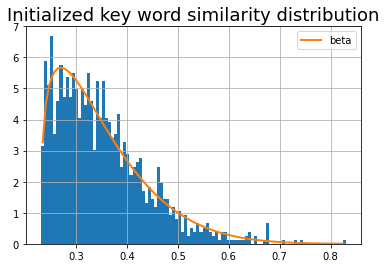

In [44]:
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions
key_embedding_together = np.vstack([GoogleNewsmodel[i] for i in list(Init_Together_Keywords) if i in GoogleNewsmodel])
cosine_similarity_values_key = np.tril(cosine_similarity(key_embedding_together), -1).reshape(-1)
cosine_similarity_values_key = cosine_similarity_values_key[cosine_similarity_values_key!=0]
cosine_similarity_values_key = cosine_similarity_values_key[cosine_similarity_values_key > np.percentile(cosine_similarity_values_key, 50)]

f_key = Fitter(cosine_similarity_values_key, distributions=["norm","beta","burr","lognorm","chi2","gamma"])
f_key = Fitter(cosine_similarity_values_key, distributions=["beta"])

f_key.fit()
f_key.summary()
plt.ylim(0, 7)
plt.title('Initialized key word similarity distribution',fontsize =18)

f_key.get_best(method = 'sumsquare_error')


In [45]:
from fitter import Fitter, get_common_distributions, get_distributions
related_embedding_together = np.vstack([GoogleNewsmodel[i] for i in list(Init_Together_Relatedwords) if i in GoogleNewsmodel])
cosine_similarity_values_related = np.tril(cosine_similarity(related_embedding_together), -1).reshape(-1)
cosine_similarity_values_related = cosine_similarity_values_related[cosine_similarity_values_related!=0]

f_related = Fitter(cosine_similarity_values_related, distributions=["norm","beta","burr","lognorm","chi2","gamma"])
f_related = Fitter(cosine_similarity_values_related, distributions=["burr"])
f_related.fit()
f_related.summary()
plt.ylim(0, 7)
plt.title('Initialized related words similarity distribution',fontsize =18)
f_related.get_best(method = 'sumsquare_error')


{'burr': {'c': 14.488174625067705,
  'd': 5.465358113604663,
  'loc': -0.9535841586479934,
  'scale': 0.9326623416846493}}

Let $n_{01}$ denote the initial total number of key words. $n_1$ denote the number of words in key-word corpus during iteration.  

There are $n_{01}(n_{01}-1)/2$ cosine similarities among the $n_{01}$ key words, denoted by $\{x_1, x_2, ..., x_{n_{01}(n_{01}-1)/2} \}$. 

Suppose that these cosine similarities are independent random variables follow a distribution with a PDF $f(x)$ and a CDF $F(x)$. 

For a new word, $w$, we can calculate its cosine similarity with each word in key-word corpus and get a new sample $x_1, x_2, ..., x_{n_1} \sim f(x)$

Let $x_{(n_1)} = max\{x_1, x_2, ..., x_{n_1} \}$ which has PDF $f_{x_{(n_1)}}(x)$. 

$$
f_{x_{(n_1)}}(x) = \frac{n_1 !}{(n_1-1)!0!} F^{n_1-1}(x) f(x) = n_1 F^{n_1-1}(x) f(x)
$$

From (For corpus size $n_1$, use $(1 - \alpha)/(n_1 -1)$ as threshold )
$$
\begin{aligned}
& \int_{-\infty}^t f_{x_{(n_1)}}(x) dx = (1 - \alpha)/(n_1 -1)  \\
\implies  &
\int_{-\infty}^t F^{n_1-1}(x)  dF(x) =  (1 - \alpha)/(n_1(n_1 -1)) \\
\overset{(s=F(x)) }{\implies} &
\int_{0}^{F(t)} s^{n_1-1}ds =  (1 - \alpha)/(n_1(n_1 -1))  \\  
\implies  &
[F(t)]^{n_1} = \frac{1 - \alpha}{n_1-1}  \\
\implies  &
F(t) = (\frac{1 - \alpha}{n_1-1})^{1/n_1} \\
\implies  & 
P(x<t) = (\frac{1 - \alpha}{n_1-1})^{1/n_1} \\
\implies  & t \  is  \ the \ (\frac{1 - \alpha}{n_1-1})^{1/n_1} \  quantile \ of \  f(x)
\end{aligned} 
$$



In [ ]:
import math
import scipy.stats
from pynverse import inversefunc
from statsmodels.distributions.empirical_distribution import ECDF

def get_max_threshold(alpha, n1, distribution, word_corpus_type , 
                  f_key = f_key, f_related = f_related, 
                  cosine_similarity_values_key= cosine_similarity_values_key,
                  cosine_similarity_values_related = cosine_similarity_values_related):  
    '''
    alpha: significant level for finding similar words 
    n1: number of words in corpus
    distribution: 'normal', 'beta','empirical'. The distribution of cosine_similarity among words
    word_corpus_type: 'key' or 'related'
    '''
    a_star = ((1-alpha)/(n1-1))**(1/n1) 

    if word_corpus_type == 'key':
        #normal 
        if distribution == 'normal':
            mu, sigma2 =  f_key.fitted_param["norm"]
            quantile = scipy.stats.norm.ppf(a_star, loc=mu, scale = sigma2)
            threshold = quantile
#             sigma = np.sqrt(sigma2)
#             threshold = sigma*quantile+mu

        #beta 
        if distribution == 'beta':
            a, b,loc, scale =  f_key.fitted_param["beta"]
            threshold = scipy.stats.beta.ppf(a_star, a=a, b=b, loc= loc, scale = scale)
            
        if distribution == 'gamma':
            a ,loc, scale = f_key.fitted_param["gamma"]
            threshold = scipy.stats.gamma.ppf(a_star, a=a,loc= loc, scale = scale)
            
        #empirical distribution 
        if distribution == 'empirical':
            ecdf = ECDF(cosine_similarity_values_key)
            eq = lambda x: np.percentile([ecdf(i) for i in np.linspace(0,1,1000)], x*100)
            threshold =  eq(a_star)
        
    
    elif word_corpus_type == 'related':
        #normal 
        if distribution == 'normal':
            mu, sigma2 =  f_related.fitted_param["norm"]
            quantile = scipy.stats.norm.ppf(a_star)
            sigma = np.sqrt(sigma2)
            threshold = sigma*quantile+mu
        #beta 
        if distribution == 'beta':
            a, b,loc, scale =  f_related.fitted_param["beta"]
            threshold = scipy.stats.beta.ppf(a_star, a=a, b=b, loc= loc, scale = scale)

        #burr 
        if distribution == 'burr':
            c, d, loc, scale =  f_related.fitted_param["burr"]
            threshold = scipy.stats.burr.ppf(a_star, c=c, d=d, loc= loc, scale = scale)
        
        #empirical distribution 
        if distribution == 'empirical':
            ecdf = ECDF(cosine_similarity_values_related)
            eq = lambda x: np.percentile([ecdf(i) for i in np.linspace(0,1,1000)], x*100)
            threshold = eq(a_star)
            
    return(threshold)


#Example
range_k = np.linspace(len(Init_Together_Keywords),500,500-len(Init_Together_Keywords)+1)
range_r = np.linspace(len(Init_Together_Relatedwords),3000,3000-len(Init_Together_Relatedwords)+1)
import matplotlib.pyplot as plt
plt.plot(range_k, [get_max_threshold(0.05, i, 'beta',word_corpus_type = 'key') for i in range_k])
plt.ylim(0.1, 0.8)
plt.plot(range_r, [get_max_threshold(0.05, i, 'burr',word_corpus_type = 'related') for i in range_r])

print(get_max_threshold(0.05, len(Init_Together_Keywords), 'beta',word_corpus_type = 'key'))
print(get_max_threshold(0.05, 500, 'beta', word_corpus_type = 'key' ))
print(get_max_threshold(0.05, len(Init_Together_Relatedwords), 'burr',word_corpus_type = 'related'))
print(get_max_threshold(0.05, 3000, 'burr', word_corpus_type = 'related' ))

In [164]:
import random
def word_corpus_expansion(Keywords, Relatedwords, input_words,  epoch, alpha=0.05, EmbeddingModel = GoogleNewsmodel):
    '''
    Keywords, Relatedwords : initialized word set 
    input_words: the words set we want to test or check
    epoch: how many epoch for the whole words set to go through
    alpha: significant level for finding similar words 
    EmbeddingModel:  GoogleNewsmodel
    '''
    ## using GoogleNewsmodel to embed the initialized word sets
    Keywords_embedding  = np.vstack([EmbeddingModel[i] for i in list(Keywords) if i in EmbeddingModel])
    Relatedwords_embedding = np.vstack([EmbeddingModel[i] for i in list(Relatedwords) if i in EmbeddingModel])

    Keywords_iter, Relatedwords_iter = Keywords.copy(), Relatedwords.copy()
    Keywords_embedding, Relatedwords_embedding = Keywords_embedding.copy(), Relatedwords_embedding.copy()
    Keywords_NUM, Relatedwords_NUM = [],[] #record number of words in each word corpus
    epoch_Keywords_NUM, epoch_Relatedwords_NUM =  [], []#record number of words in each word corpus at the end of each epoch 
    
    epoch = epoch

    input_words = list(set(input_words))
    print('Will test', len(input_words), 'words in Intermediate answers ' )
    
    cosine_similarity_values_key = np.tril(cosine_similarity(Keywords_embedding), -1).reshape(-1)
    cosine_similarity_values_key = cosine_similarity_values_key[cosine_similarity_values_key!=0]
    cosine_similarity_values_key = cosine_similarity_values_key[cosine_similarity_values_key > np.percentile(cosine_similarity_values_key, 50)]
    f_key = Fitter(cosine_similarity_values_key, distributions=["norm","beta","burr","lognorm","chi2","gamma"])
    f_key.fit()
    
    cosine_similarity_values_related = np.tril(cosine_similarity(Relatedwords_embedding), -1).reshape(-1)
    cosine_similarity_values_related = cosine_similarity_values_related[cosine_similarity_values_related != 0]
    f_related = Fitter(cosine_similarity_values_related, distributions=["norm","beta","burr","lognorm","chi2","gamma"])
    f_related.fit()
    
    print('start similarity threshold:')
    print('key: ', get_max_threshold(alpha, len(Keywords_iter), 'beta',word_corpus_type = 'key'))
    print('related: ', get_max_threshold(alpha, len(Relatedwords_iter), 'burr',word_corpus_type = 'related'))
    

    for epo in range(epoch):
#       random.shuffle(input_words) 
        Int_Ans_words = input_words

        t0 = time.time()
        num_for_time = 0
        num_total = len(Int_Ans_words)
        for word in Int_Ans_words:
           
            if num_for_time % 1000 == 0 and not num_for_time == 0:
                elapsed = format_time(time.time() - t0)
                rows_per_sec = (time.time() - t0) / num_for_time
                remaining_sec = rows_per_sec * (num_total - num_for_time)
                remaining = format_time(remaining_sec)
                print(' Corpus  {:>5,}  of  {:>5,}. Elapsed: {:}. Keyword size: {:}. Relatedword size: {:}.'.format(num_for_time, num_total, elapsed,len(Keywords_iter),len(Relatedwords_iter)))
            #check symptom-key words: 
            n1 = len(Keywords_iter)
            threshold = get_max_threshold(alpha, n1, 'beta',word_corpus_type = 'key')
            word_checkpoint = Check_valid_word(EmbeddingModel, Stopwords, Keywords_iter, 
                                               Keywords_embedding, word, 
                                               cos_similar_ratio=threshold, similar_num=1)  
            if word_checkpoint['flag']: #if word should be updated
                Keywords_iter = set(word_checkpoint['new_WordQ'])
                Keywords_embedding = word_checkpoint['new_word_embed']
                 
            #check symptom-related words: 
            n2 = len(Relatedwords_iter)
            threshold = get_max_threshold(alpha, n2, 'burr',word_corpus_type = 'related')
            word_checkpoint = Check_valid_word(EmbeddingModel, Stopwords+list(Keywords_iter), Relatedwords_iter, 
                                               Relatedwords_embedding, word, 
                                               cos_similar_ratio=threshold, similar_num=1)
            if word_checkpoint['flag'] and word_checkpoint['reason'] == 'NA': #if word should be updated
                Relatedwords_iter = set(word_checkpoint['new_WordQ'])
                Relatedwords_embedding = word_checkpoint['new_word_embed']

            Keywords_iter = Keywords_iter - Relatedwords_iter 
            Keywords_embedding = np.vstack([EmbeddingModel[i] for i in list(Keywords_iter) if i in EmbeddingModel])

            num_for_time +=1
            if num_for_time%100 == 0:  #for every 100 words, update the size of word corpus
                Keywords_NUM.append(len(Keywords_iter))
                Relatedwords_NUM.append(len(Relatedwords_iter)) 

        epoch_Keywords_NUM.append(len(Keywords_iter))
        epoch_Relatedwords_NUM.append(len(Relatedwords_iter))

        elapsed = format_time(time.time() - t0)
        print('Epoch %d Done!'%(epo+1), elapsed)
    
    print('final similarity threshold:')
    print(get_max_threshold(alpha, len(Keywords_iter), 'beta', word_corpus_type = 'key' ))
    print(get_max_threshold(alpha, len(Relatedwords_iter), 'burr', word_corpus_type = 'related' ))
    print('---------  DONE! ---------')
    result_dic  = {"Keywords":Keywords_iter, "Relatedwords":Relatedwords_iter,
                   "Keywords_embedding":Keywords_embedding, "Relatedwords_embedding":Relatedwords_embedding, 
                   "Keywords_NUM":Keywords_NUM,"Relatedwords_NUM":Relatedwords_NUM,
                   "epoch_Keywords_NUM":epoch_Keywords_NUM, "epoch_Relatedwords_NUM":epoch_Relatedwords_NUM,
                   "Int_Ans_words":input_words}
    
    return(result_dic)
    

### Word Corpus interation update (together)

In [181]:
<prevent running>
#BERT:
input_words_BERTlarge = Int_Ans_BERTlarge
input_words_BERTlarge = [item for sublist in input_words_BERTlarge for item in sublist]
input_words_BERTlarge = [re.findall(r"[\w']+", input_words_BERTlarge[i]) for i in range(len(input_words_BERTlarge)) ]
input_words_BERTlarge = [item.lower() for sublist in input_words_BERTlarge for item in sublist]

#BioBERT:
input_words_BioBERTlarge = Int_Ans_BioBERTlarge
input_words_BioBERTlarge = [item for sublist in input_words_BioBERTlarge for item in sublist]
input_words_BioBERTlarge = [re.findall(r"[\w']+", input_words_BioBERTlarge[i]) for i in range(len(input_words_BioBERTlarge))]
input_words_BioBERTlarge = [item.lower() for sublist in input_words_BioBERTlarge for item in sublist]

#Union:
input_words_together = list(set(input_words_BERTlarge).union(set(input_words_BioBERTlarge)))

Together_word_corpus_dic = word_corpus_expansion(Init_Together_Keywords, Init_Together_Relatedwords, 
                                                  input_words_together,  
                                                  epoch=5, alpha=0.05, EmbeddingModel = GoogleNewsmodel)


Will test 5201 words in Intermediate answers 
start similarity threshold:
key:  0.5195638273782659
related:  0.2694602941917785
 Corpus  1,000  of  5,201. Elapsed: 0:00:02. Keyword size: 113. Relatedword size: 355.
 Corpus  2,000  of  5,201. Elapsed: 0:00:04. Keyword size: 163. Relatedword size: 639.
 Corpus  3,000  of  5,201. Elapsed: 0:00:08. Keyword size: 213. Relatedword size: 934.
 Corpus  4,000  of  5,201. Elapsed: 0:00:14. Keyword size: 274. Relatedword size: 1235.
 Corpus  5,000  of  5,201. Elapsed: 0:00:22. Keyword size: 341. Relatedword size: 1536.
Epoch 1 Done! 0:00:24
 Corpus  1,000  of  5,201. Elapsed: 0:00:11. Keyword size: 363. Relatedword size: 1672.
 Corpus  2,000  of  5,201. Elapsed: 0:00:22. Keyword size: 372. Relatedword size: 1744.
 Corpus  3,000  of  5,201. Elapsed: 0:00:35. Keyword size: 381. Relatedword size: 1808.
 Corpus  4,000  of  5,201. Elapsed: 0:00:48. Keyword size: 387. Relatedword size: 1842.
 Corpus  5,000  of  5,201. Elapsed: 0:01:02. Keyword size: 39

In [165]:
# save 
#import numpy as np
#np.save('./output_files/Word_Corpus_result_epoch5_together.npy', Together_word_corpus_dic)

#load
Together_word_corpus_dic = np.load('./output_files/Word_Corpus_result_epoch5_together.npy',allow_pickle='TRUE').item()
Together_Keywords = Together_word_corpus_dic['Keywords']
Together_Relatedwords = Together_word_corpus_dic['Relatedwords']
Keywords_NUM_Together = Together_word_corpus_dic['Keywords_NUM']
Relatedwords_NUM_Together = Together_word_corpus_dic['Relatedwords_NUM']
epoch_Keywords_NUM_Together = Together_word_corpus_dic['epoch_Keywords_NUM']
epoch_Relatedwords_NUM_Together = Together_word_corpus_dic['epoch_Relatedwords_NUM']
Int_Ans_words_Together = Together_word_corpus_dic['Int_Ans_words']

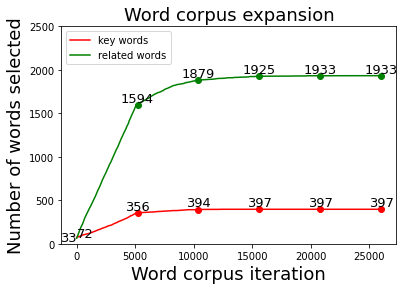

There are 397 key words, 1933 related words


In [166]:
# import matplotlib.pyplot as plt
# plt.plot(range(0, len(Allwords_NUM_BERTlarge)*100, 100),Allwords_NUM_BERTlarge,  'b', label="all words")
# plt.plot(range(0, len(Keywords_NUM_BERTlarge)*100, 100), Keywords_NUM_BERTlarge, 'r', label="key words")
# plt.plot(range(0, len(Relatedwords_NUM_BERTlarge)*100, 100), Relatedwords_NUM_BERTlarge,'g', label="related words")
# plt.plot([len(Int_Ans_words_BERTlarge)*i for i in range(1,6)],[epoch_Allwords_NUM_BERTlarge[i] for i in range(5)],'ob')
# plt.plot([len(Int_Ans_words_BERTlarge)*i for i in range(1,6)],[epoch_Keywords_NUM_BERTlarge[i] for i in range(5)],'or')
# plt.plot([len(Int_Ans_words_BERTlarge)*i for i in range(1,6)],[epoch_Relatedwords_NUM_BERTlarge[i] for i in range(5)],'og')
# plt.xlabel('Word Corpus Iteration',fontsize= 18)
# plt.ylabel('Number of selected word',fontsize =18)
# plt.title('BERT QA + Word Corpus Expansion',fontsize =18)
# plt.legend(loc='upper left')
# plt.show()
# print('BERT: There are %d key words, %d related words, and %d all words'%(len(BERTlarge_Keywords),len(BERTlarge_Relatedwords),len(BERTlarge_Allwords) ))

# import matplotlib.pyplot as plt
# plt.plot(range(0, len(Allwords_NUM_BioBERTlarge)*100, 100),    Allwords_NUM_BioBERTlarge, 'b', label="all words")
# plt.plot(range(0, len(Keywords_NUM_BioBERTlarge)*100, 100),    Keywords_NUM_BioBERTlarge,'r', label="key words")
# plt.plot(range(0, len(Relatedwords_NUM_BioBERTlarge)*100, 100),Relatedwords_NUM_BioBERTlarge,'g', label="related words")
# plt.plot([len(Int_Ans_words_BioBERTlarge)*i for i in range(1,6)],[epoch_Allwords_NUM_BioBERTlarge[i] for i in range(5)],'ob')
# plt.plot([len(Int_Ans_words_BioBERTlarge)*i for i in range(1,6)],[epoch_Keywords_NUM_BioBERTlarge[i] for i in range(5)],'or')
# plt.plot([len(Int_Ans_words_BioBERTlarge)*i for i in range(1,6)],[epoch_Relatedwords_NUM_BioBERTlarge[i] for i in range(5)],'og')
# plt.xlabel('Word Corpus Iteration',fontsize= 18)
# plt.ylabel('Number of selected word',fontsize =18)
# plt.title('BioBERT QA + Word Corpus Expansion',fontsize =18)
# plt.legend(loc='upper left')
# plt.show()
# print('BioBERT: There are %d key words, %d related words, and %d all words'%(len(BioBERTlarge_Keywords),len(BioBERTlarge_Relatedwords),len(BioBERTlarge_Allwords) ))

import matplotlib.pyplot as plt
# plt.plot(range(0, len(Allwords_NUM_Together)*100, 100),    Allwords_NUM_Together, 'b', label="all words")
plt.plot(range(0, len(Keywords_NUM_Together)*100, 100),    Keywords_NUM_Together,'r', label="key words")
plt.plot(range(0, len(Relatedwords_NUM_Together)*100, 100),Relatedwords_NUM_Together,'g', label="related words")
# plt.plot([len(Int_Ans_words_Together)*i for i in range(1,6)],[epoch_Allwords_NUM_Together[i] for i in range(5)],'ob')
plt.plot([len(Int_Ans_words_Together)*i for i in range(1,6)],[epoch_Keywords_NUM_Together[i] for i in range(5)],'or')
plt.plot([len(Int_Ans_words_Together)*i for i in range(1,6)],[epoch_Relatedwords_NUM_Together[i] for i in range(5)],'og')
plt.xlabel('Word corpus iteration',fontsize= 18)
plt.ylabel('Number of words selected',fontsize =18)
plt.title('Word corpus expansion',fontsize =18)
plt.legend(loc='upper left')
plt.ylim(0, 2500)
for i in range(len(epoch_Keywords_NUM_Together)):
    if np.isnan(epoch_Keywords_NUM_Together[i]) == 0:
        plt.text([len(Int_Ans_words_Together)*i for i in range(1,6)][i], 
                 [epoch_Keywords_NUM_Together[i] for i in range(5)][i], 
                 epoch_Keywords_NUM_Together[i], horizontalalignment='center',
                 verticalalignment='bottom', fontsize=13)

    if np.isnan(epoch_Relatedwords_NUM_Together[i]) == 0:
        plt.text([len(Int_Ans_words_Together)*i for i in range(1,6)][i], 
                 [epoch_Relatedwords_NUM_Together[i] for i in range(5)][i], 
                 epoch_Relatedwords_NUM_Together[i], horizontalalignment='center',
                 verticalalignment='bottom', fontsize=13)
plt.text(0, len(Init_Together_Relatedwords),len(Init_Together_Relatedwords), horizontalalignment='center',
                 verticalalignment='baseline', ha='right', fontsize=13)
plt.text(0, len(Init_Together_Keywords),len(Init_Together_Keywords), horizontalalignment='center',
                 verticalalignment='baseline', ha='left',fontsize=13)
plt.show()
print('There are %d key words, %d related words'%(len(Together_Keywords),len(Together_Relatedwords)))




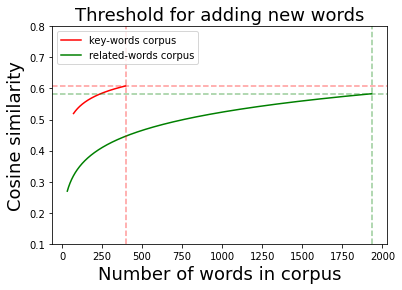

In [50]:
range_k = np.linspace(len(Init_Together_Keywords),len(Together_Keywords),len(Together_Keywords)-len(Init_Together_Keywords)+1)
range_r = np.linspace(len(Init_Together_Relatedwords), len(Together_Relatedwords), len(Together_Relatedwords)-len(Init_Together_Relatedwords)+1)
import matplotlib.pyplot as plt
key_th = [get_max_threshold(0.05, i, 'beta',word_corpus_type = 'key') for i in range_k]
related_th = [get_max_threshold(0.05, i, 'burr',word_corpus_type = 'related') for i in range_r]
plt.plot(range_k, key_th,'r',label="key-words corpus")
plt.plot(range_r, related_th,color='g',label="related-words corpus" )
plt.ylim(0.1, 0.8)

plt.xlabel('Number of words in corpus',fontsize= 18)
plt.ylabel('Cosine similarity',fontsize =18)
plt.title('Threshold for adding new words',fontsize =18)
#plt.axvline(len(Init_Together_Keywords), color='r', linestyle='--',alpha = 0.4) # vertical
plt.axvline(len(Together_Keywords), color='r', linestyle='--',alpha = 0.4) # vertical
#plt.axhline(key_th[0], color='r',linestyle='--',alpha = 0.4) # horizontal
plt.axhline(key_th[-1], color='r',linestyle='--',alpha = 0.4) # horizontal

#plt.axvline(len(Init_Together_Relatedwords), color='g', linestyle='--',alpha = 0.4) # vertical
plt.axvline(len(Together_Relatedwords), color='g', linestyle='--',alpha = 0.4) # vertical
#plt.axhline(related_th[0], color='g',linestyle='--',alpha = 0.4) # horizontal
plt.axhline(related_th[-1], color='g',linestyle='--',alpha = 0.4) # horizontal
plt.legend(loc='upper left')

plt.show()



In [167]:
#BERT large
import re
from termcolor import colored


sym_key_query_BERTlarge =  Together_Keywords.union({'taste and smell','smell and taste','taste / smell','smell / taste',
                                       'taste/smell','smell/taste','heart','rate','lack','energy','no','not'})- {'symptoms','symptom'}
sym_related_query_BERTlarge = Together_Relatedwords.union({'of','or','all','symptoms','symptom'})

Int_Ans_BERTlarge_flat = [item for sublist in Int_Ans_BERTlarge for item in sublist]

color_flat_Int_Ans_BERTlarge = [re.findall(r"\btaste and smell\b|\bsmell and taste\b|taste\s*/\s*smell|smell\s*/\s*taste|\w+|[^\w\s]", w) for w in Int_Ans_BERTlarge_flat] 
color_flat_Int_Ans_color1_BERTlarge =[list([ws,[(w.lower() in list(sym_key_query_BERTlarge))*1 for w in ws]]) for ws in color_flat_Int_Ans_BERTlarge]
color_flat_Int_Ans_color2_BERTlarge =[list([ws,[(w.lower() in list(sym_related_query_BERTlarge))*2 for w in ws]]) for ws in color_flat_Int_Ans_BERTlarge]

color_flat_Int_Ans_colorAll_BERTlarge = [[color_flat_Int_Ans_color1_BERTlarge[i][0], 
                                [color_flat_Int_Ans_color1_BERTlarge[i][1][j]+color_flat_Int_Ans_color2_BERTlarge[i][1][j] for j in range(len(color_flat_Int_Ans_color2_BERTlarge[i][1]))]] 
                                for i in range(len(color_flat_Int_Ans_color2_BERTlarge))]

color_flat_Int_Ans_colorAllcode_BERTlarge = [[colored(ws[0][i],"red", attrs=['blink','underline']) if ws[1][i]==1 
                                       else colored(ws[0][i],"green", attrs=['blink','underline']) if ws[1][i]==2
                                       else ws[0][i] 
                                       for i in range(len(ws[0]))] for ws in color_flat_Int_Ans_colorAll_BERTlarge]

color_flat_Int_Ans_colorAllcode_BERTlarge = [" ".join(ws).lower() for ws in color_flat_Int_Ans_colorAllcode_BERTlarge]
for col_text in color_flat_Int_Ans_colorAllcode_BERTlarge:
     print(col_text)


fatigue , and some minor lingering chest tightness / shortness of breath
no sense of smell , ear / sinus pressure that seems to be slowlyyy getting better , fatigue
my stomach
my stomach is generally unsettled
pressure headache , increased burping , difficulty swallowing , burning in nose
dizziness , migraine , loss of smell
my ear pressure was killer at points and i had dizziness , migraine , loss of smell
mine started coming back after 8 days of no smell
mine started coming back after 8 days of no smell . definitely a gradual process
breathing issues / relying on my inhaler a bit more than normal
breathing issues , mild chest pain , & lightheadedness
breathing
breathing symptoms
a stubborn secondary sinus infection and lingering blurred vision
a stubborn secondary sinus infection and lingering blurred vision that will hopefully resolve when the sinuses resolve
i lost my sense of smell
my heart rate spikes / i feel weird with just a sip now
my vision is a little blurrier than before i

hardly being able to walk . i laid in a bath or on a bag of ice for 5 days
i ’ m talking about hardly being able to walk
my wife
fatigue , cough and diarrhea . followed by loss of taste and smell
tiredness after activity 2nd — - cough 3rd - — - diarrhea 4th — — body aches
body aches 5th — — - low grade fever 6th — — fatigue 7th — — - loss of taste and smell
my appetite has come and gone . last couple days i ’ m not hungry
my appetite has come and gone . last couple days i ’ m not hungry . last week i could not eat enough
false negatives
if i push it just a little to much i get severely exhausted
bad gag reflex
bad gag reflex not doing well
nose test
nose test was nothing . a little uncomfortable but not a bad as i expected
it really looks like many people are not taking it seriously anymore
lost taste and smell
at day 14 i lost taste and smell
it ’ s a little difficult without positive and negative
shortness of breath , light cough , body aches and diarrhea
sore and headache
overweight

running was the only thing keeping me sane as well , and not being able to run ( along with contracting the coronavirus
fevers and muscle pain
fevers and muscle pain also came back
fevers and muscle pain also came back when i tried doing just a 1 / 2 mile light jog
muscle pain and fevers
no pneumonia , no damage to any internal structures
no pneumonia , no damage to any internal structures . bloodwork all completely normal and no markers of any inflammation
i had a chest x - ray which was completely unremarkable . no pneumonia , no damage to any internal structures
fevers and severe muscle pain and soreness
my biggest issues now are just fevers and severe muscle pain and soreness
covid insomnia
muscle pain and also helps with the covid insomnia
joint pain and sore muscles
mainly just joint pain and sore muscles now
crying and feeling hopeless
generalized anxiety disorder but like you , on my 4th week of symptoms and also an active runner . i spent so many days just crying and feeling h

In [168]:
#BioBERT large
import re
from termcolor import colored

sym_key_query_BioBERTlarge =  Together_Keywords.union({'taste and smell','smell and taste','taste / smell','smell / taste',
                                       'taste/smell','smell/taste','heart','rate','lack','energy','no','not'})- {'symptoms','symptom'}
sym_related_query_BioBERTlarge = Together_Relatedwords.union({'of','or','all','symptoms','symptom'})


Int_Ans_BioBERTlarge_flat = [item for sublist in Int_Ans_BioBERTlarge for item in sublist]

color_flat_Int_Ans_BioBERTlarge = [re.findall(r"\btaste and smell\b|\bsmell and taste\b|taste\s*/\s*smell|smell\s*/\s*taste|\w+|[^\w\s]", w) for w in Int_Ans_BioBERTlarge_flat] 
color_flat_Int_Ans_color1_BioBERTlarge =[list([ws,[(w.lower() in list(sym_key_query_BioBERTlarge))*1 for w in ws]]) for ws in color_flat_Int_Ans_BioBERTlarge]
color_flat_Int_Ans_color2_BioBERTlarge =[list([ws,[(w.lower() in list(sym_related_query_BioBERTlarge))*2 for w in ws]]) for ws in color_flat_Int_Ans_BioBERTlarge]

color_flat_Int_Ans_colorAll_BioBERTlarge = [[color_flat_Int_Ans_color1_BioBERTlarge[i][0], 
                                [color_flat_Int_Ans_color1_BioBERTlarge[i][1][j]+color_flat_Int_Ans_color2_BioBERTlarge[i][1][j] for j in range(len(color_flat_Int_Ans_color2_BioBERTlarge[i][1]))]] 
                                for i in range(len(color_flat_Int_Ans_color2_BioBERTlarge))]

color_flat_Int_Ans_colorAllcode_BioBERTlarge = [[colored(ws[0][i],"red", attrs=['blink','underline']) if ws[1][i]==1 
                                       else colored(ws[0][i],"green", attrs=['blink','underline']) if ws[1][i]==2
                                       else ws[0][i] 
                                       for i in range(len(ws[0]))] for ws in color_flat_Int_Ans_colorAll_BioBERTlarge]

color_flat_Int_Ans_colorAllcode_BioBERTlarge = [" ".join(ws).lower() for ws in color_flat_Int_Ans_colorAllcode_BioBERTlarge]
for col_text in color_flat_Int_Ans_colorAllcode_BioBERTlarge:
     print(col_text)


no sense of smell
fatigue , and some minor lingering chest tightness / shortness of breath
no sense of smell , ear / sinus pressure that seems to be slowlyyy getting better
stomach is generally unsettled
pressure headache , increased burping , difficulty swallowing , burning in nose
dizziness , migraine , loss of smell
my ear pressure was killer at points and i had dizziness , migraine , loss of smell
dizziness , migraine , loss of smell . i ’ m recovered , but still relying on my inhaler a bit
no smell
breathing issues / relying on my inhaler a bit more than normal
breathing issues , mild chest pain , & lightheadedness
spent the night & morning with breathing issues , mild chest pain , & lightheadedness
the symptoms my dr said were just lingering
the symptoms my dr said were just lingering are just about clear
breathing
breathing symptoms
low grade fever , chest pains
lingering symptoms that may be due to the secondary infection ) . dr said people are having the low grade fever , ches

shortness of breath
it ' s hard to breathe , and of course it ' s hard to think straight under these conditions
very painful sensations in back muscles and joints , making it very hard to find a comfortable sleeping position
smelly farts
a mild case of smelly farts
we only had mild symptoms
by the time they called , we only had mild symptoms
we do have some folklore about traditional ways to treat illnesses
we do have some folklore about traditional ways to treat illnesses and we have some knowledge about the medical properties of our herbs
worried about creating antibiotic resistance bacteria
grammar mistakes
obnoxious
they ' re especially obnoxious
if there are any grammar mistakes
grammar mistakes in the original story
obnoxious about that
lost taste/smell
mild symptoms and then lost taste/smell
scratchy throat , had headache , aches , slight shortness of breath and mild cough
minor symptoms worth the risk
my sciatic nerve was inflamed
tight hips normally and i think my sciatic nerv

fluctuated a bit up and down
stress and illness
stress and illness can throw it off
congestion , sore throat , body aches and headache
no sense of smell
just the no sense of smell
i don ’ t have a cough at all , no symptoms at all . just the no sense of smell
cranial nerves are inflamed
my case was super mild . is it because our cranial nerves are inflamed
sharp pain in the back of my right eye
one of the least talked about symptoms that i don ’ t see brought up much was the sharp pain in the back of my right eye
fever , chills , fatigue , slight sore throat and coughing
i had symptoms of fever , chills , fatigue , slight sore throat and coughing on march 10
brain fog , dream - like perception ( feels like i ’ m high ) , fatigue , dull head pressure , and light sensitivity
brain fog and headache are constant , but no cough and lung discomfort
sleep has suffered greatly
anxiety in general about it , and my sleep has suffered greatly
sleep has suffered greatly . please let me know how yo

the only symptom that had lingered was fatigue and blurry vision
fatigue and blurry vision . however , today i noticed that i ’ m not tasting my food
the only symptom that had lingered was fatigue and blurry vision . however , today i noticed that i ’ m not tasting my food
anxiety attacks
anxiety attacks lol doctors r stupid
gi symptoms , fever , and severe fatigue
gi symptoms , fever , and severe fatigue . those symptoms are now gone , but now i am developing shortness of breathe
annoying and creepy
shortness of breathe , and i can ’ t seem to do much without feeling like i need to catch my breathe
my lungs shortly after feel like they ’ re on fire
if i as much as have a conversation with my wife that lasts over 30 min . , my lungs shortly after feel like they ’ re on fire
my lungs shortly after feel like they ’ re on fire . i ’ ve never felt pain like that in my lungs
unusual testicular pain
unusual testicular pain recently . it ’ s mild , lasts only a few minutes and occurs about on

### Gather symptoms

In [170]:
#BERT
num_per_Int_Ans_BERTlarge = [len(list_sym) for list_sym in Int_Ans_BERTlarge]  #how many loose symptoms for each body
index_Int_Ans_BERTlarge = [0]+ list(np.cumsum(num_per_Int_Ans_BERTlarge)) 
gathered_sym_BERTlarge = []
for k in range(len(color_flat_Int_Ans_colorAll_BERTlarge)):
    case_k = color_flat_Int_Ans_colorAll_BERTlarge[k]
    temp_sym = [case_k[0][i] if case_k[1][i] > 0 else ' ' for i in range(len(case_k[0])) ]
    temp_sym = ' '.join(temp_sym).split('   ') 
    temp_sym = [x.strip() for x in temp_sym] #remove space before and after each string 
    temp_sym = [x for x in temp_sym if x]  #remove blank string 
    remove_label = ''.join([str(l) for l in case_k[1]]).split('0')
    remove_label = [x.strip() for x in remove_label if x]
    remove_label = ['1' in l for l in remove_label]
    syms = [temp_sym[i] for i in range(len(temp_sym)) if remove_label[i]]
    gathered_sym_BERTlarge.append(syms)

gathered_sym_per_body_BERTlarge = [] 
for i in range(1, len(index_Int_Ans_BERTlarge)):
    gathered_sym_bodyi = gathered_sym_BERTlarge[index_Int_Ans_BERTlarge[i-1]:index_Int_Ans_BERTlarge[i]]
    gathered_sym_bodyi_flatten  = [item for sublist in gathered_sym_bodyi for item in sublist]
    gathered_sym_per_body_BERTlarge.append(list(set(gathered_sym_bodyi_flatten))) #remove repeated symptom for one body

for symlist in gathered_sym_per_body_BERTlarge:  
    for sym in symlist:
        if set(re.findall(r"[\w']+", sym))-set(Stopwords)-sym_related_query_BERTlarge == set():#remove "only stopword/realated" symptom
            symlist.remove(sym) 

In [171]:
#BioBERT
num_per_Int_Ans_BioBERTlarge = [len(list_sym) for list_sym in Int_Ans_BioBERTlarge]  #how many loose symptoms for each body
index_Int_Ans_BioBERTlarge = [0]+ list(np.cumsum(num_per_Int_Ans_BioBERTlarge)) 
gathered_sym_BioBERTlarge = []
for k in range(len(color_flat_Int_Ans_colorAll_BioBERTlarge)):
    case_k = color_flat_Int_Ans_colorAll_BioBERTlarge[k]
    temp_sym = [case_k[0][i] if case_k[1][i] > 0 else ' ' for i in range(len(case_k[0])) ]
    temp_sym = ' '.join(temp_sym).split('   ') 
    temp_sym = [x.strip() for x in temp_sym] #remove space before and after each string 
    temp_sym = [x for x in temp_sym if x]  #remove blank string 
    remove_label = ''.join([str(l) for l in case_k[1]]).split('0')
    remove_label = [x.strip() for x in remove_label if x]
    remove_label = ['1' in l for l in remove_label]
    syms = [temp_sym[i] for i in range(len(temp_sym)) if remove_label[i]]
    gathered_sym_BioBERTlarge.append(syms)

gathered_sym_per_body_BioBERTlarge = [] 
for i in range(1, len(index_Int_Ans_BioBERTlarge)):
    gathered_sym_bodyi = gathered_sym_BioBERTlarge[index_Int_Ans_BioBERTlarge[i-1]:index_Int_Ans_BioBERTlarge[i]]
    gathered_sym_bodyi_flatten  = [item for sublist in gathered_sym_bodyi for item in sublist]
    gathered_sym_per_body_BioBERTlarge.append(list(set(gathered_sym_bodyi_flatten))) #remove repeated symptom for one body

for symlist in gathered_sym_per_body_BioBERTlarge:  
    for sym in symlist:
        if set(re.findall(r"[\w']+", sym))-set(Stopwords)-sym_related_query_BioBERTlarge == set():#remove "only stopword/realated" symptom
            symlist.remove(sym) 

In [172]:
print('BERT:')
print('number of authors',len(gathered_sym_per_body_BERTlarge))
print('---------------- before UMLS ------------------')
flatten_gathered_sym_per_body_BERTlarge = [item.lower() for sublist in gathered_sym_per_body_BERTlarge for item in sublist]
print('number of symptoms',len(flatten_gathered_sym_per_body_BERTlarge))
print('unique number of symptoms',len(set(flatten_gathered_sym_per_body_BERTlarge)))

print('\n')

print('BioBERT:')
print('number of authors',len(gathered_sym_per_body_BioBERTlarge))
print('---------------- before UMLS ------------------')
flatten_gathered_sym_per_body_BioBERTlarge = [item.lower() for sublist in gathered_sym_per_body_BioBERTlarge for item in sublist]
print('number of symptoms',len(flatten_gathered_sym_per_body_BioBERTlarge))
print('unique number of symptoms',len(set(flatten_gathered_sym_per_body_BioBERTlarge)))

BERT:
number of authors 3619
---------------- before UMLS ------------------
number of symptoms 6642
unique number of symptoms 2167


BioBERT:
number of authors 3930
---------------- before UMLS ------------------
number of symptoms 7688
unique number of symptoms 2430


### Convert symptom words to vectors by BERT hidden layer

In [173]:
from transformers import BertTokenizer, BertModel
def symtom_to_vector(model, tokenizer, text):
    marked_text = "[CLS] " + text + " [SEP]"
    tokenized_text = tokenizer.tokenize(marked_text)

    indexed_tokens = tokenizer.convert_tokens_to_ids(tokenized_text)
    segments_ids = [1] * len(tokenized_text)

    tokens_tensor = torch.tensor([indexed_tokens])
    segments_tensors = torch.tensor([segments_ids])

    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
        hidden_states = outputs[2]
    
    token_embeddings = torch.stack(hidden_states, dim=0)
    token_embeddings = torch.squeeze(token_embeddings, dim=1)   # Remove dimension 1, the "batches".
    token_embeddings = token_embeddings.permute(1,0,2)
    
    sentence_embedding = torch.mean(token_embeddings, dim=0) # Calculate the average of all token vectors.

    sentence_embedding_avg = torch.mean(sentence_embedding, dim=0) # Calculate the average of all transformer layers.
    sentence_embedding_cat = torch.cat((sentence_embedding[-1,:], sentence_embedding[-2,:], 
                                        sentence_embedding[-3,:], sentence_embedding[-4,:]), dim=0)
    
    return (sentence_embedding_avg, sentence_embedding_cat)
    

In [58]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)
model.eval()

# or (work not well)
# tokenizer = BertTokenizer.from_pretrained('dmis-lab/biobert-v1.1')
# model = BertModel.from_pretrained('dmis-lab/biobert-v1.1', output_hidden_states = True)
# model.eval()

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [84]:
# BERT 
<prevent running>
sym2vec_dic_BERTlarge = {}
for sym in flatten_gathered_sym_per_body_BERTlarge:
    if sym in sym2vec_dic_BERTlarge:
        continue
    sym_embeddings = symtom_to_vector(model , tokenizer, sym)
    sym2vec_dic_BERTlarge[sym] = (sym_embeddings[0].numpy(), sym_embeddings[1].numpy())
#np.save('./output_files/sym2vec_dic_BERTlarge.npy', sym2vec_dic_BERTlarge)

word2vec_dic_BERTlarge = {}
for keyw in list(sym_key_query_BERTlarge) +['no','not']:
    if keyw in word2vec_dic_BERTlarge:
        continue
    keyw_embeddings = symtom_to_vector(model , tokenizer, keyw)
    word2vec_dic_BERTlarge[keyw] = (keyw_embeddings[0].numpy(), keyw_embeddings[1].numpy())
#np.save('./output_files/word2vec_dic_BERTlarge.npy', word2vec_dic_BERTlarge)


In [85]:
# BioBERT 
<prevent running>  
sym2vec_dic_BioBERTlarge = {}   
for sym in flatten_gathered_sym_per_body_BioBERTlarge:   
    if sym in sym2vec_dic_BioBERTlarge:  
        continue
    sym_embeddings = symtom_to_vector(model , tokenizer, sym)
    sym2vec_dic_BioBERTlarge[sym] = (sym_embeddings[0].numpy(), sym_embeddings[1].numpy())
#np.save('./output_files/sym2vec_dic_BioBERTlarge.npy', sym2vec_dic_BioBERTlarge)

word2vec_dic_BioBERTlarge = {}
for keyw in list(sym_key_query_BioBERTlarge) +['no','not']:
    if keyw in word2vec_dic_BioBERTlarge:
        continue
    keyw_embeddings = symtom_to_vector(model , tokenizer, keyw)
    word2vec_dic_BioBERTlarge[keyw] = (keyw_embeddings[0].numpy(), keyw_embeddings[1].numpy())
#np.save('./output_files/word2vec_dic_BioBERTlarge.npy', word2vec_dic_BioBERTlarge) 



In [5]:
#read 
# for local:
sym2vec_dic_BERTlarge = np.load('./output_files/sym2vec_dic_BERTlarge.npy',allow_pickle='TRUE').item()
word2vec_dic_BERTlarge = np.load('./output_files/word2vec_dic_BERTlarge.npy',allow_pickle='TRUE').item()

sym2vec_dic_BioBERTlarge = np.load('./output_files/sym2vec_dic_BioBERTlarge.npy',allow_pickle='TRUE').item()
word2vec_dic_BioBERTlarge = np.load('./output_files/word2vec_dic_BioBERTlarge.npy',allow_pickle='TRUE').item()

# # for colab:
# sym2vec_dic_BERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/sym2vec_dic_BERTlarge.npy',allow_pickle='TRUE').item()
# word2vec_dic_BERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/word2vec_dic_BERTlarge.npy',allow_pickle='TRUE').item()
# sym2vec_dic_BioBERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/sym2vec_dic_BioBERTlarge.npy',allow_pickle='TRUE').item()
# word2vec_dic_BioBERTlarge = np.load('/content/drive/MyDrive/Colab_Notebooks/Reddit_NLP/output_files/word2vec_dic_BioBERTlarge.npy',allow_pickle='TRUE').item()


### DKV - Kmeans  (Dynamic Key-Value K means clustering)

In [109]:
from sklearn.metrics.pairwise import cosine_similarity
def cos_sim(vec1,vec2):
    cosine_sim = cosine_similarity(np.vstack([vec1, vec2]))[0,1]
    return(cosine_sim)

In [110]:
def val_2_key(center_dic, match_dic):
    '''
    input:
    center_dic: dictionart with "key" keyword and "value" vector of keyword
    match_dic: dictionary with "key" symptom and "value" vector of symptom
    
    output:
    iter_dic: dictionary with "key" new key words, and "value" symptom
    '''
    iter_dic = {w: [] for w in center_dic.keys()}
    for s in match_dic.keys():
        cos_sim_list = [cos_sim(match_dic[s][0], center_dic[w][0]) for w in center_dic.keys()]
        max_index = cos_sim_list.index(max(cos_sim_list)) 
        word = list(center_dic.keys())[max_index]
        iter_dic[word].append(s)
    return(iter_dic)


In [111]:
def Recalculating_centroid(target_dic, val_dic):
    '''
    input:
        target_dic:  with "key" key words, and "value" symptom, calculate mean centroid of this dictionary's values 
        val_dic: vectors of values are from this dictionary
    output:
        dictionary with keys and numerical vectors(centroid)
    '''
    new_centroid_dic  = target_dic.copy()
    for k, vs in target_dic.items():
        new_center = np.mean(np.vstack([val_dic[i][0] for i in vs]), axis=0)
        new_centroid_dic[k] = (new_center, "_") #_ :placeholder 
    return (new_centroid_dic)

In [112]:
from collections import defaultdict
def merge_cluster(target_dic, center_dic, threshold = 0.95):
    '''
    output: dictionary
    '''
    center_vec_vstack = np.vstack( [center_dic[x][0] for x in list(target_dic)] )
    names = list(center_dic)
    A = cosine_similarity(center_vec_vstack)
    A_triu = np.triu(A, 1)
    result_index = np.where(A_triu > threshold)
    paired_index = [(result_index[0][i],result_index[1][i]) for i in range(len(result_index[0]))]
    

    iset = set([frozenset(s) for s in paired_index])  # Convert to a set of sets
    group_index = []
    while(iset):                  # While there are sets left to process:
        nset = set(iset.pop())      # Pop a new set
        check = len(iset)           # Does iset contain more sets
        while check:                # Until no more sets to check:
            check = False
            for s in iset.copy():       # For each other set:
                if nset.intersection(s):  # if they intersect:
                    check = True            # Must recheck previous sets
                    iset.remove(s)          # Remove it from remaining sets
                    nset.update(s)          # Add it to the current set
        group_index.append(tuple(nset))  # Convert back to a list of tuples

    group_names = [[names[i] for i in group] for group in group_index]
    return (group_names)

### start

In [62]:
import itertools 

In [113]:
def DKV_Kmeans_Algorithm(word2vec_dic, sym2vec_dic, max_iter=50, int_lowerbound_similar = 0.95, 
                         lowestbound_similar = 0.94, decay = 0.001):
    '''
    word2vec_dic: dictionary (key: keywords;  values: their numerical vectors)
    sym2vec_dic: dictionary (key: symptoms need to be clustered; values: their numerical vectors)
    max_iter: maximum number of iterations 
    int_lowerbound_similar: for the initial round, if two clusters have similarity > int_lowerbound_similar, then merge them.
    lowestbound_similar: the lowest similarity that can merge two clusters 
    decay: similarity decay, for t-th round, the merge-similarity decrease by decay value. 
    '''
    word2vec_dic_iter = word2vec_dic.copy()
    #initialize cluster: assign symptom to keyword
    iter_dic = val_2_key(word2vec_dic_iter, sym2vec_dic)
    iter_dic = {(k,): v for k, v in iter_dic.items() if v} #remove item which has blank value []
    print('-- start --','number of clusters:',len(iter_dic))

    iter_len = [[len(v) for k,v in iter_dic.items()]]
    #iteration:
    for t in range(max_iter):
        #recalculate centroid of every cluster 
        new_centroid_dic = Recalculating_centroid(iter_dic, sym2vec_dic)

        #assign words to clusters
        center_iter_dic = val_2_key(new_centroid_dic, word2vec_dic_iter)
        try:
            center_iter_dic = {k: list(sum(v, ())) for k, v in center_iter_dic.items()}  #convert a list of tuples into a list
        except TypeError:  #if values in center_iter_dic are already list type
            pass
        center_iter_dic = {k: v for k, v in center_iter_dic.items() if v}  #remove item which has blank value []

        #recalculate centroid of words dictionary 
        word2vec_dic_iter_temp0 = dict([(tuple(v), [k]) for k, v in center_iter_dic.items()])    

        if t==0: #the first loop
            word2vec_dic_iter_temp1 = {k: sum([iter_dic[(ki,)] for ki in k if (ki,) in iter_dic],[]) for k, v in word2vec_dic_iter_temp0.items()}  
        else:
            word2vec_dic_iter_temp1 = {k: iter_dic[k] for k, v in word2vec_dic_iter_temp0.items()}    

        word2vec_dic_iter_temp2 = {k: v for k, v in word2vec_dic_iter_temp1.items() if v}  #remove item which has blank value []
        word2vec_dic_iter = Recalculating_centroid(word2vec_dic_iter_temp2, sym2vec_dic)

        #assign symptom to words 
        iter_dic = val_2_key(word2vec_dic_iter, sym2vec_dic)
        iter_dic = {k: v for k, v in iter_dic.items() if v}  #remove item which has blank value []

        #merge groups 
        group_names = merge_cluster(target_dic=iter_dic, center_dic = word2vec_dic_iter, 
                                    threshold = max(int_lowerbound_similar - t*decay, lowestbound_similar))
        for g in group_names:
            iter_dic[sum(g,())] = sum([iter_dic[i] for i in g],[])
            for del_item in g:
                del iter_dic[del_item] 
        iter_dic = {tuple(set(k),): v for k, v in iter_dic.items() if v}   #reorder the keys for multi-label keys
        word2vec_dic_iter = Recalculating_centroid(iter_dic, sym2vec_dic)
        iter_len.append([len(v) for k,v in iter_dic.items()])
        print('-- iteration %d --'%(t),'number of clusters:',len(iter_len[t]))
        
        if t>0 and iter_len[t+1] == iter_len[t] and iter_len[t+1] == iter_len[t-1]:  #when sizes of each cluster are fixed, stop
            break
    print('Done')
    return({'iter_dic':iter_dic,  'iter_len':iter_len})


In [ ]:
<prevent running>
print('------- DKV Kmeans BERTlarge -------')
DKV_result_BERTlarge = DKV_Kmeans_Algorithm(word2vec_dic_BERTlarge, sym2vec_dic_BERTlarge, max_iter=50, 
                                            int_lowerbound_similar = 1.0, lowestbound_similar = 0.95, decay = 0.005)
print('------- DKV Kmeans BioBERTlarge -------')
DKV_result_BioBERTlarge = DKV_Kmeans_Algorithm(word2vec_dic_BioBERTlarge, sym2vec_dic_BioBERTlarge, max_iter=50, 
                                            int_lowerbound_similar = 1.0, lowestbound_similar = 0.95, decay = 0.005)


In [114]:
import numpy as np

In [6]:
# save 
# np.save('./output_files/DKV_result_BERTlarge.npy', DKV_result_BERTlarge)
# np.save('./output_files/DKV_result_BioBERTlarge.npy', DKV_result_BioBERTlarge)
iter_dic_BERTlarge = np.load('./output_files/DKV_result_BERTlarge.npy',allow_pickle='TRUE').item()['iter_dic']
iter_len_BERTlarge = np.load('./output_files/DKV_result_BERTlarge.npy',allow_pickle='TRUE').item()['iter_len']
iter_dic_BioBERTlarge = np.load('./output_files/DKV_result_BioBERTlarge.npy',allow_pickle='TRUE').item()['iter_dic']
iter_len_BioBERTlarge = np.load('./output_files/DKV_result_BioBERTlarge.npy',allow_pickle='TRUE').item()['iter_len']


# iter_dic_BERTlarge = np.load('./output_files/DKV_result_BERTlarge.npy',allow_pickle='TRUE').item()['iter_dic']
# iter_len_BERTlarge = np.load('./output_files/DKV_result_BERTlarge.npy',allow_pickle='TRUE').item()['iter_len']
# iter_dic_BioBERTlarge = np.load('./output_files/DKV_result_BioBERTlarge.npy',allow_pickle='TRUE').item()['iter_dic']
# iter_len_BioBERTlarge = np.load('./output_files/DKV_result_BioBERTlarge.npy',allow_pickle='TRUE').item()['iter_len']


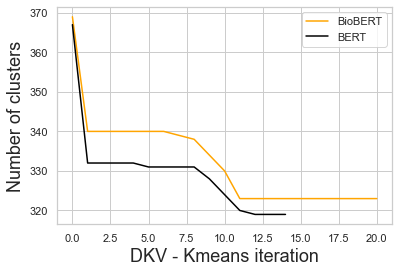

In [66]:
import seaborn as sns
sns.set_theme(style="whitegrid")
plt.plot([len(i) for i in iter_len_BioBERTlarge],'orange', label='BioBERT')
plt.plot([len(i) for i in iter_len_BERTlarge], color ='black', label='BERT')
plt.xlabel('DKV - Kmeans iteration',fontsize= 18)
plt.ylabel('Number of clusters',fontsize =18)
plt.legend(loc='upper right')
plt.show()

### Visualization by PCA

In [ ]:
# sym_emb_list = []
# sym_name_list = []
# group_name_list = []
# for k, v in sym2vec_dic.items():
#     sym_name_list.append(k)
#     sym_emb_list.append(v[0])    
# sym_emb_array= np.vstack(sym_emb_list)

# for i in sym_name_list:
#     for c_name, syms in iter_dic.items():  
#         if i in syms:
#             group_name_list.append(c_name)

In [ ]:
# from sklearn.decomposition import PCA
# from sklearn.decomposition import FastICA

# pca = PCA(n_components = 2)
# #pca = FastICA(n_components = 2)

# sym_emb_PCA2 = pca.fit_transform(sym_emb_array)
# df = pd.DataFrame(dict(pc1=sym_emb_PCA2[:,0], pc2=sym_emb_PCA2[:,1], G_name = group_name_list, sym_name =sym_name_list ))
# df = df[df.groupby('G_name')['G_name'].transform('count').ge(50)] #frequency greater than 60


In [ ]:
# from matplotlib.pyplot import figure

# figure(figsize=(10, 10), dpi=80)

# groups = df.groupby("G_name")
# for name, group in groups:
#     plt.plot(group["pc1"], group["pc2"], marker="o", linestyle="",alpha =1, label=name)
#     plt.xlabel('Principal component 1',fontsize= 18)
#     plt.ylabel('Principal component 2',fontsize =18)
    
# for i in range(len(df)):
#     x = df["pc1"].tolist()[i]
#     y = df["pc2"].tolist()[i]
#     if i % 15 == 0:
#         label = df['sym_name'].tolist()[i]
#         plt.annotate(label, # this is the text
#                      (x,y), # these are the coordinates to position the label
#                      textcoords="offset points", # how to position the text
#                      xytext=(0,0), # distance from text to points (x,y)
#                      ha='center') # horizontal alignment can be left, right or center 


### Visualization by TSNE

In [9]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns

In [39]:
def TSNE_Visualization(sym2vec_dic, iter_dic, plotname, freq=20):
    '''
    sym2vec_dic: symptom to vector dictionary
    plotname: string
    iter_dic: Clustered symptoms by DKV_Kmeans_Algorithm, iter_dic_BERTlarge or iter_dic_BioBERTlarge
    freq: only show the symptoms which have frequency >= freq
    '''
    sym_emb_list = []
    sym_name_list = []
    group_name_list = []
    for k, v in sym2vec_dic.items():
        sym_name_list.append(k)
        sym_emb_list.append(v[0])    
    sym_emb_array= np.vstack(sym_emb_list)

    for i in sym_name_list:
        for c_name, syms in iter_dic.items():  
            if i in syms:
                group_name_list.append(c_name) 
    
    random.seed(2022)
    sym_emb_array_TSNE = TSNE(n_components=2,init='random').fit_transform(sym_emb_array)
    df_TSNE = pd.DataFrame(dict(TSNE1=sym_emb_array_TSNE[:,0], 
                                TSNE2=sym_emb_array_TSNE[:,1], 
                                G_name = group_name_list, 
                                sym_name =sym_name_list))
    df_TSNE = df_TSNE[df_TSNE.groupby('G_name')['G_name'].transform('count').ge(freq)] 
    groups = df_TSNE.groupby("G_name")
    
    for name, group in groups:
        plt.scatter(group["TSNE1"], group["TSNE2"], marker="o", alpha = 0.5, label=name)
        plt.xlabel('TSNE component 1',fontsize= 18)
        plt.ylabel('TSNE component 2',fontsize =18)
        plt.grid(True)
    plt.title(plotname, fontsize =20)
    

    existLabel = set() 
    for i in range(len(df_TSNE)):
        x = df_TSNE["TSNE1"].tolist()[i]
        y = df_TSNE["TSNE2"].tolist()[i]
        label = df_TSNE['G_name'].tolist()[i]
        if label not in existLabel and label[0] not in {'no','not'}:
            existLabel.add(label)
            plt.annotate(label[0], # this is the text, i.e. first key word
                         (x,y), # these are the coordinates to position the label
                         textcoords="offset points", # how to position the text
                         fontsize=15,
                         xytext=(0,0), # distance from text to points (x,y)
                         ha='center') # horizontal alignment can be left, right or center 

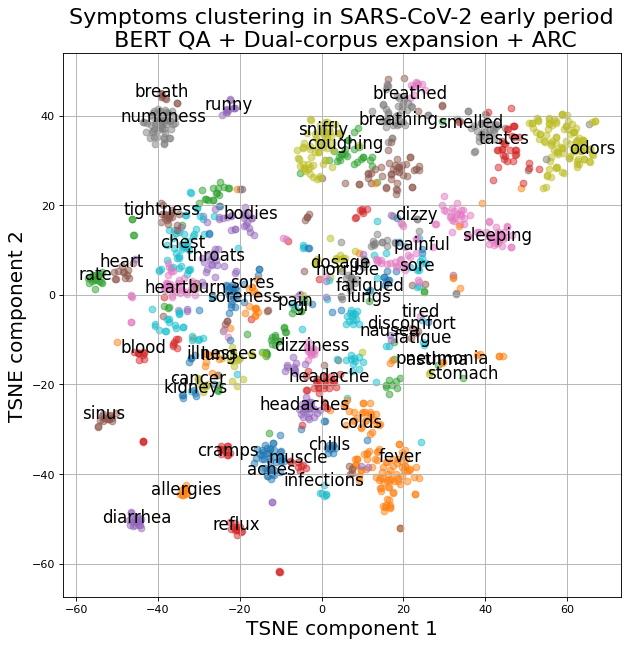

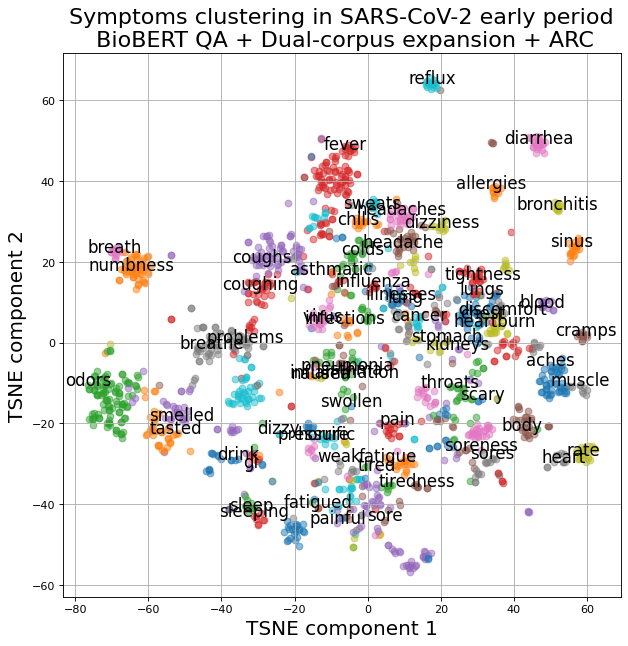

In [43]:
figure(figsize=(9, 9), dpi=80)
TSNE_Visualization(sym2vec_dic_BERTlarge, iter_dic_BERTlarge, plotname ='Symptoms clustering in SARS-CoV-2 early period\n BERT QA + Dual-corpus expansion + ARC', freq=10)
figure(figsize=(9, 9), dpi=80)
TSNE_Visualization(sym2vec_dic_BioBERTlarge, iter_dic_BioBERTlarge, plotname ='Symptoms clustering in SARS-CoV-2 early period\n BioBERT QA + Dual-corpus expansion + ARC', freq=10)


In [ ]:
###################################################

### UMLS file

In [ ]:
# #!pip install owlready2
<prevent running>
from owlready2 import * 
from owlready2.pymedtermino2 import * 
from owlready2.pymedtermino2.umls import * 
## default_world.set_backend(filename = "pym.sqlite3")  #make sure only run this line once!

In [ ]:
# #take very long time!
<prevent running>
import_umls("umls-2021AA-metathesaurus.zip", terminologies = ["ICD10", "SNOMEDCT_US", "CUI"])
default_world.save()
# original fda code: (do not work)
#import_umls("./umls-2021AA-full.zip", terminologies = ["CUI"])  
#Concept Unique Identifiers (CUI), "ICD10", "SNOMEDCT_US"

In [ ]:
<prevent running>
PYM = get_ontology("http://PYM/").load()
CUI = PYM["CUI"]

In [ ]:
### make UMLS dictionary 
<prevent running>
symptom_synonyms = {}
for i in range(0, 6000000):#6000000
    if CUI['C'+ str(i).zfill(7)]:
        concept = CUI['C'+ str(i).zfill(7)] 
        if concept.label!=[]:
            sym = str(concept.label[0])
            symptom_synonyms[sym] = [str(i) for i in concept.synonyms]
        #CUI['C'+ str(i).zfill(7)].label
print(len(symptom_synonyms))

#import numpy as np
#np.save('./symptom_synonyms.npy', symptom_synonyms)

### Read UMLS dictionary

In [118]:
import re
symptom_synonyms_dic = np.load('./symptom_synonyms.npy',allow_pickle='TRUE').item()
symptom_synonyms_dic = dict((k.lower(), v) for k, v in symptom_synonyms_dic.items())  #make keys lowers
symptom_synonyms_dic = dict((k, [vi.lower() for vi in v]) for k, v in symptom_synonyms_dic.items()) #make values lowers
symptom_synonyms_dic = dict((k, [k]+v) for k, v in symptom_synonyms_dic.items())      #key also in values
symptom_synonyms_dic_words = dict((k, set(re.findall(r"[\w']+", ' '.join(v)))) for k, v in symptom_synonyms_dic.items()) #make values' word


### Make UMLS dictionary smaller

In [119]:
print("original UMLS dictionary has", len(symptom_synonyms_dic), "items")

symptom_synonyms_basic_dic = {}
for k, vs in symptom_synonyms_dic.items():
    symptom_synonyms_basic_dic_keywords_set = set(re.findall(r"[\w']+", ' '.join(vs)))
    if (sym_key_query_BERTlarge.union(sym_key_query_BioBERTlarge)-{'no','not'}).intersection(symptom_synonyms_basic_dic_keywords_set) != set():
        if 'no' not in k.split():
            symptom_synonyms_basic_dic[k] = vs
    else:
        continue
print("smaller UMLS dictionary has", len(symptom_synonyms_basic_dic), "items")



original UMLS dictionary has 359084 items
smaller UMLS dictionary has 157931 items


### UMLS map

In [188]:
from difflib import SequenceMatcher
def find_common_str(list_of_str):
    '''
    Input: 
        list_of_str: list of strings.
    Output: 
        Python dictionary with format: {'common string': frequency}
    '''
    substring_counts={}
    
    if len(list_of_str) == 1:
        if(list_of_str[0] not in substring_counts):
            substring_counts[list_of_str[0]]=1
        else:
            substring_counts[list_of_str[0]]+=1
        
    else: 
        for i in range(0, len(list_of_str)-1):
            for j in range(i+1,len(list_of_str)):
                string1 = list_of_str[i]
                string2 = list_of_str[j]
                match = SequenceMatcher(None, string1, string2).find_longest_match(0, len(string1), 0, len(string2))
                # only consider complete word:
                if (match.a == 0 or string1[match.a]==' ' or string1[match.a-1]==' ') and (match.a + match.size==len(string1) or string1[match.a+match.size-1:match.a+match.size]==' ' or string1[match.a+match.size:match.a+match.size+1]==' '):        
                    matching_substring=string1[match.a: match.a+match.size]
                    matching_substring = matching_substring.strip()
                    if(matching_substring not in substring_counts):
                        substring_counts[matching_substring]=1
                    else:
                        substring_counts[matching_substring]+=1
    ordered_dic = {k: v for k, v in sorted(substring_counts.items(),reverse=True, key=lambda item: item[1])}
    
    if not ordered_dic: #no common string at all
        ordered_dic = {' ': 1} 
    return(ordered_dic)


In [178]:
import copy
def softmax(vector):
    if not vector:
        return [0]
    max_value = max(vector)
    xrel = [i - max_value for i in vector]
    return np.exp(xrel) / np.exp(xrel).sum()

def UMLS_mapping_method(iter_dic, UMLS_basic_dic):
    '''
    Input: 
        iter_dic: key-values dictionary after DKV clustering method (iter_dic_BERTlarge or iter_dic_BioBERTlarge)
        UMLS_basic_dic: UMLS concept unique identifier (CUI) dictionary
    Output: 
        Python dictionary with format: ('confident key word', 'other word'(s)): ['refined symptom'(s), ['UMLS symptom name']]
    '''
    iter_dic_add = copy.deepcopy(iter_dic)
    try:
        del iter_dic_add[('no',)]  #remove two clusters
        del iter_dic_add[('not',)]
    except:
        pass 
    
    ### add a most confident key for each cluster 
    for k, v in iter_dic.items():
        if k not in {('no',), ('not',)}:
            common_key_freq_list = find_common_str(v)
            common_key_freq_list = {k:v for k,v in common_key_freq_list.items() if k not in {'and','or','of','symptoms','symptom'}} #common word should not be and/or
            if len(common_key_freq_list)!=0: 
                common_key_freq = softmax(common_key_freq_list.values())[0]
                common_key = list(common_key_freq_list.keys())[0] #most frequent word(s) 
                if common_key_freq > 0.8 or common_key in k:  #if frequent word dominate or common string already in keys
                    iter_dic_add[(common_key,)+k] = iter_dic_add[k] #update the keys in dictionary (add common string to the key)
                    del iter_dic_add[k]  #delete the old keys
                    continue 

            iter_dic_add[(' ',)+k] = iter_dic_add[k] #update the keys in dictionary (add ' ' to the key)
            del iter_dic_add[k]  #delete the old keys

    ### mapping: 
    for k, vs in iter_dic_add.items():
        flag = 0

        #(1) determined by the most confident key:
        for kd, vsd in UMLS_basic_dic.items():
            if k[0]: 
                if k[0] in vsd and 'structure' not in kd and 'function' not in kd:
                    iter_dic_add[k].append([kd])
                    flag = 1
                    break

        #(2) determined by the other keys:
        if flag == 0: 
            tem_check_dic = {} 
            for kd, vsd in UMLS_basic_dic.items():
                if any ([kd == i and i in find_common_str(vs) for i in k[1:]]): #this keys should also appear on common_str
                    flag = 2
                    iter_dic_add[k].append([kd])
                    break

                #(3) determined by values:
                if any([(i in vsd and 'structure' not in kd and 'function' not in kd) for i in vs]):
                    flag = 3
                    if kd not in tem_check_dic:
                        tem_check_dic[kd] = 1
                    else:
                        tem_check_dic[kd] += 1    

            if flag == 3:
               
                max_value = max(tem_check_dic.values())
                final_kd = [k for k,v in tem_check_dic.items() if v == max_value]
                if len(final_kd) == 1:  #only one maximum value 
                    iter_dic_add[k].append([final_kd[0]])
                else: #multiple maximum value 
                    iter_dic_add[k].append([final_kd[0]])

            
            if flag == 0:
                #iter_dic_add[k].append([' '])  #if not mapped successfully, add [' ']
                iter_dic_add[k][-1] = [k[0]]
    
    
    #check "s": 
    valid_name_so_far = [vi[-1][0] for ki,vi in iter_dic_add.items() if vi[-1]!=[' ']] #all the vaild name 
    valid_name_with_s = [i for i in valid_name_so_far if i[-1]=='s']  #all the vaild name with s
    common_wo_s = list(set([i[:-1] for i in valid_name_with_s]).intersection(set(valid_name_so_far))) 
    common_w_s = [i+'s' for i in common_wo_s]
    for k, vs in iter_dic_add.items():
        if vs[-1][0] in common_wo_s:
            if vs[-1][0] not in UMLS_basic_dic and vs[-1][0]+'s' in UMLS_basic_dic:
                vs[-1][0] = vs[-1][0]+'s'
        if vs[-1][0] in common_w_s:
            if vs[-1][0] not in UMLS_basic_dic and vs[-1][0][:-1] in UMLS_basic_dic:
                vs[-1][0] = vs[-1][0][:-1]

    return(iter_dic_add)


In [279]:
<prevent running>
ULMS_mapping_sym_BERTlarge = UMLS_mapping_method(iter_dic_BERTlarge,UMLS_basic_dic=symptom_synonyms_basic_dic)
ULMS_mapping_sym_BioBERTlarge = UMLS_mapping_method(iter_dic_BioBERTlarge,UMLS_basic_dic = symptom_synonyms_basic_dic)

In [179]:
# np.save('./output_files/ULMS_mapping_sym_BERTlarge.npy', {'ULMS_mapping_sym_BERTlarge':ULMS_mapping_sym_BERTlarge}) 
# np.save('./output_files/ULMS_mapping_sym_BioBERTlarge.npy', {'ULMS_mapping_sym_BioBERTlarge':ULMS_mapping_sym_BioBERTlarge}) 
ULMS_mapping_sym_BERTlarge = np.load('./output_files/ULMS_mapping_sym_BERTlarge.npy',allow_pickle='TRUE').item()['ULMS_mapping_sym_BERTlarge']
ULMS_mapping_sym_BioBERTlarge = np.load('./output_files/ULMS_mapping_sym_BioBERTlarge.npy',allow_pickle='TRUE').item()['ULMS_mapping_sym_BioBERTlarge']

### Map original symptoms to standard names

In [180]:
standard_sym_per_body_BioBERTlarge =  []
for i in range(len(gathered_sym_per_body_BioBERTlarge)):
    standard_sym_per_body_BioBERTlarge.append([])
    for j in gathered_sym_per_body_BioBERTlarge[i]:
        for k,v in ULMS_mapping_sym_BioBERTlarge.items():
            if j in v:
                standard_sym_per_body_BioBERTlarge[i].append(v[-1][0])

standard_sym_per_body_BERTlarge =  []
for i in range(len(gathered_sym_per_body_BERTlarge)):
    standard_sym_per_body_BERTlarge.append([])
    for j in gathered_sym_per_body_BERTlarge[i]:
        for k,v in ULMS_mapping_sym_BERTlarge.items():
            if j in v:
                standard_sym_per_body_BERTlarge[i].append(v[-1][0])

### Get time-based symptoms

In [200]:
timebased_syms_Early_BERTlarge = pd.DataFrame() #record for later using to create positive dataframe
timebased_syms_Early_BERTlarge['author'] = [i.split('2020-')[0] for i in ori_Int_Ans_content_id_BERTlarge]
timebased_syms_Early_BERTlarge['time'] = ori_Int_Ans_time_id_BERTlarge
timebased_syms_Early_BERTlarge['symptoms'] = standard_sym_per_body_BERTlarge
# timebased_syms_Early_BERTlarge.to_csv('./output_files/2020MarAprMay/timebased_syms_Early_BERTlarge.csv',index=False, encoding='utf_8_sig')
timebased_syms_Early_BioBERTlarge = pd.DataFrame() #record for later using to create positive dataframe
timebased_syms_Early_BioBERTlarge['author'] = [i.split('2020-')[0] for i in ori_Int_Ans_content_id_BioBERTlarge] 
timebased_syms_Early_BioBERTlarge['time'] = ori_Int_Ans_time_id_BioBERTlarge
timebased_syms_Early_BioBERTlarge['symptoms'] = standard_sym_per_body_BioBERTlarge
# timebased_syms_Early_BioBERTlarge.to_csv('./output_files/2020MarAprMay/timebased_syms_Early_BioBERTlarge.csv',index=False, encoding='utf_8_sig')


### Count (by post)

In [182]:
print('--------------- BERT --------------- ')
count_list = [item for sublist in standard_sym_per_body_BERTlarge for item in list(set(sublist))]
count_list = [i for i in count_list if i!=' ']  #remove ' ' 
from collections import Counter
Counter(count_list).most_common()
symptom_freq_dataframe = pd.DataFrame.from_dict(Counter(count_list), orient='index').reset_index()
symptom_freq_dataframe = symptom_freq_dataframe.rename(columns={0: "count_freq"})
print(symptom_freq_dataframe.sort_values(by='count_freq', ascending=False).head(20))
# symptom_freq_dataframe.to_csv('./output_files/2020MarAprMay/Freq_by_post_BERT.csv', index=False)


print('--------------- BioBERT --------------- ')
count_list = [item for sublist in standard_sym_per_body_BioBERTlarge for item in list(set(sublist))]
count_list = [i for i in count_list if i!=' ']  #remove ' ' 
from collections import Counter
Counter(count_list).most_common()
symptom_freq_dataframe = pd.DataFrame.from_dict(Counter(count_list), orient='index').reset_index()
symptom_freq_dataframe = symptom_freq_dataframe.rename(columns={0: "count_freq"})
print(symptom_freq_dataframe.sort_values(by='count_freq', ascending=False).head(20))
# symptom_freq_dataframe.to_csv('./output_files/2020MarAprMay/Freq_by_post_BioBERT.csv', index=False)


--------------- BERT --------------- 
                     index  count_freq
34                coughing         373
29                   fever         350
2   loss of sense of smell         244
61                headache         209
36     sore throat symptom         196
39                    pain         195
0                  dyspnea         186
4           lack of energy         170
64        chest discomfort         154
67                   aches         141
14                  breath         125
3              tight chest          97
44                  nausea          95
13              chest pain          94
33        diarrhea symptom          93
58                   sleep          86
11         stops breathing          76
60                   chill          74
8                dizziness          73
42                   tired          70
--------------- BioBERT --------------- 
                          index  count_freq
39                     coughing         451
16            

### Count (by user)

In [183]:
print('Total number of positive users:', len(set(positive_data['author'])))

ori_Int_Ans_content_id_BERTlarge = np.load('./output_files/Int_Ans_BERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BERTlarge']
user_id_BERTlarge = [ori_Int_Ans_content_id_BERTlarge[i].split('2020-')[0] for i in range(len(ori_Int_Ans_content_id_BERTlarge))]
count_dic_BERTlarge = {} 
for i in range(len(user_id_BERTlarge)):
    if user_id_BERTlarge[i] not in count_dic_BERTlarge: 
        count_dic_BERTlarge[user_id_BERTlarge[i]] = set()
        count_dic_BERTlarge[user_id_BERTlarge[i]] = count_dic_BERTlarge[user_id_BERTlarge[i]].union(set(standard_sym_per_body_BERTlarge[i]))
    else:
        count_dic_BERTlarge[user_id_BERTlarge[i]] = count_dic_BERTlarge[user_id_BERTlarge[i]].union(set(standard_sym_per_body_BERTlarge[i]))
count_dic_BERTlarge = {k:v for k,v in count_dic_BERTlarge.items() if v!=set()}
print('NLP BERT: there are %d'%(len(count_dic_BERTlarge)), 'authors have been extracted COVID symptoms' ) 
print('On average, each author reported %f unique symptoms' %np.mean([len(v) for k,v in count_dic_BERTlarge.items()]))


ori_Int_Ans_content_id_BioBERTlarge = np.load('./output_files/Int_Ans_BioBERTlarge_and_ID.npy',allow_pickle='TRUE').item()['ori_Int_Ans_content_id_BioBERTlarge']
user_id_BioBERTlarge = [ori_Int_Ans_content_id_BioBERTlarge[i].split('2020-')[0] for i in range(len(ori_Int_Ans_content_id_BioBERTlarge))]
count_dic_BioBERTlarge = {}
for i in range(len(user_id_BioBERTlarge)):
    if user_id_BioBERTlarge[i] not in count_dic_BioBERTlarge: 
        count_dic_BioBERTlarge[user_id_BioBERTlarge[i]] = set()
        count_dic_BioBERTlarge[user_id_BioBERTlarge[i]] = count_dic_BioBERTlarge[user_id_BioBERTlarge[i]].union(set(standard_sym_per_body_BioBERTlarge[i]))
    else:
        count_dic_BioBERTlarge[user_id_BioBERTlarge[i]] = count_dic_BioBERTlarge[user_id_BioBERTlarge[i]].union(set(standard_sym_per_body_BioBERTlarge[i]))
count_dic_BioBERTlarge = {k:v for k,v in count_dic_BioBERTlarge.items() if v!=set()}
print('NLP BioBERT: there are %d'%(len(count_dic_BioBERTlarge)), 'authors have been extracted COVID symptoms' ) 
print('On average, each author reported %f unique symptoms' %np.mean([len(v) for k,v in count_dic_BioBERTlarge.items()]))


Total number of positive users: 310
NLP BERT: there are 288 authors have been extracted COVID symptoms
On average, each author reported 11.527778 unique symptoms
NLP BioBERT: there are 294 authors have been extracted COVID symptoms
On average, each author reported 12.598639 unique symptoms


In [184]:
print('--------------- BERT --------------- ')
count_list = [item for ks,vs in count_dic_BERTlarge.items() for item in list(vs)]
count_list = [i for i in count_list if i !=' ']  #remove ' ' 

from collections import Counter
Counter(count_list).most_common()
symptom_freq_dataframe = pd.DataFrame.from_dict(Counter(count_list), orient='index').reset_index()
symptom_freq_dataframe = symptom_freq_dataframe.rename(columns={0: "count_freq"})
symptom_freq_dataframe['freq'] = round(symptom_freq_dataframe['count_freq']/len(count_dic_BERTlarge),3)
print(symptom_freq_dataframe.sort_values(by='count_freq', ascending=False).head(30))
# symptom_freq_dataframe.to_csv('./output_files/2020MarAprMay/Freq_by_user_BERT.csv', index=False)


print('--------------- BioBERT --------------- ')
count_list = [item for ks,vs in count_dic_BioBERTlarge.items() for item in list(vs)]
count_list = [i for i in count_list if i !=' ']  #remove ' ' 

from collections import Counter
Counter(count_list).most_common()
symptom_freq_dataframe = pd.DataFrame.from_dict(Counter(count_list), orient='index').reset_index()
symptom_freq_dataframe = symptom_freq_dataframe.rename(columns={0: "count_freq"})
symptom_freq_dataframe['freq'] = round(symptom_freq_dataframe['count_freq']/len(count_dic_BioBERTlarge),3)
print(symptom_freq_dataframe.sort_values(by='count_freq', ascending=False).head(30))
# symptom_freq_dataframe.to_csv('./output_files/2020MarAprMay/Freq_by_user_BioBERT.csv', index=False)


--------------- BERT --------------- 
                        index  count_freq   freq
40                   coughing         154  0.535
2                       fever         152  0.528
8      loss of sense of smell         115  0.399
59                   headache         112  0.389
30        sore throat symptom         108  0.375
37                       pain         100  0.347
6                     dyspnea          98  0.340
19             lack of energy          92  0.319
64           chest discomfort          89  0.309
66                      aches          85  0.295
10                     breath          77  0.267
9                 tight chest          58  0.201
62                      chill          57  0.198
42                      tired          56  0.194
56                      sleep          53  0.184
32           diarrhea symptom          53  0.184
21                 chest pain          50  0.174
26                  dizziness          47  0.163
43                     nausea  